<a href="https://colab.research.google.com/github/TtvTooSmart/Application-Portal/blob/dsc%2Fdevelopment/major.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'heart-diseases:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F875294%2F1490956%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240524%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240524T171336Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D59b85112a7610a6d655514f94e55385b9955619302a9bf70a1265181b69a63dfb798ef7eb9e6a2248eec56b32654b4fc6b61f5eba4995661b44528fc36fd80d04c3c0b04651694f07001777e09de12d6397dd34dbe8a778383193c1f90e494b428f7f28b6213465d0984cdc8548004a4051af80e643478550de0cb0d5dc9b7e318ea79865c2b0443a48f4ba1bb3b8a6c85e1e0268869fc258c0c12134391aac6b5b12ee2d27a46c61ce9180c76ff934c2666e6a71f0394accc23daf31400bdd3ac7445d9d99db84c6cb1163b462d7d71ec13978f196654f4eaa6329417c535e4d64e41d0340fbf8c4ef5824d5545686e76d0af716e241bf12c61f131bada3e4a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 59478 bytes downloaded
Downloaded and uncompressed: heart-diseases
Data source import complete.


# Coronary-Heart-Disease-Prediction

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.utils import resample
# Data Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# Data Splitting
from sklearn.model_selection import train_test_split
# Data Scaling
from sklearn.preprocessing import MinMaxScaler
#Data Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, classification_report
# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
#Ensembling
from mlxtend.classifier import StackingCVClassifier


In [12]:
#data overview
df_data = pd.read_csv(r"../input/heart-diseases/datasets_4123_6408_framingham.csv")
df_data.head(20)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
5,0,43,2.0,0,0.0,0.0,0,1,0,228.0,180.0,110.0,30.30,77.0,99.0,0
6,0,63,1.0,0,0.0,0.0,0,0,0,205.0,138.0,71.0,33.11,60.0,85.0,1
7,0,45,2.0,1,20.0,0.0,0,0,0,313.0,100.0,71.0,21.68,79.0,78.0,0
8,1,52,1.0,0,0.0,0.0,0,1,0,260.0,141.5,89.0,26.36,76.0,79.0,0
9,1,43,1.0,1,30.0,0.0,0,1,0,225.0,162.0,107.0,23.61,93.0,88.0,0


In [13]:
df_data.shape

(4240, 16)

The dataset contains 4240 redords and 16 columns including the target column.

In [14]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


this shows an evweview of the Columns, non-null count and the data types of the dataset

## EXPLORATORY DATA ANALYSIS

* Handling missing and duplicate data.
* Univariate, Bivariate and Multivariate Analysis.
* Individual Features descriptive statistics.
* Visualizing Target attribute shows if the dataset is imbalanced.
* Resampling imbalanced dataset by oversampling positive case.
* Feature Selection


### missing data handling

In [15]:
df_data.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

It shows the number of np.nan or null values or missing values are present in the dataset:

   * education: 105
   * cigsPerDay: 29
   * BPMeds: 53
   * totChol: 50
   * BMI: 19
   * heartRate: 1
   * glucose: 388

In [16]:
df_data.duplicated().sum()

0

 there are no Duplicated Values present in the dataset.

In [17]:
print((df_data["glucose"].mode())[0])

75.0


In [18]:
df_data["glucose"].fillna((df_data["glucose"].mode())[0], inplace=True)

In [19]:
df_data.dropna(inplace=True)
df_data.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

The missing data has been handled and all other rows containing missing values has been removed.

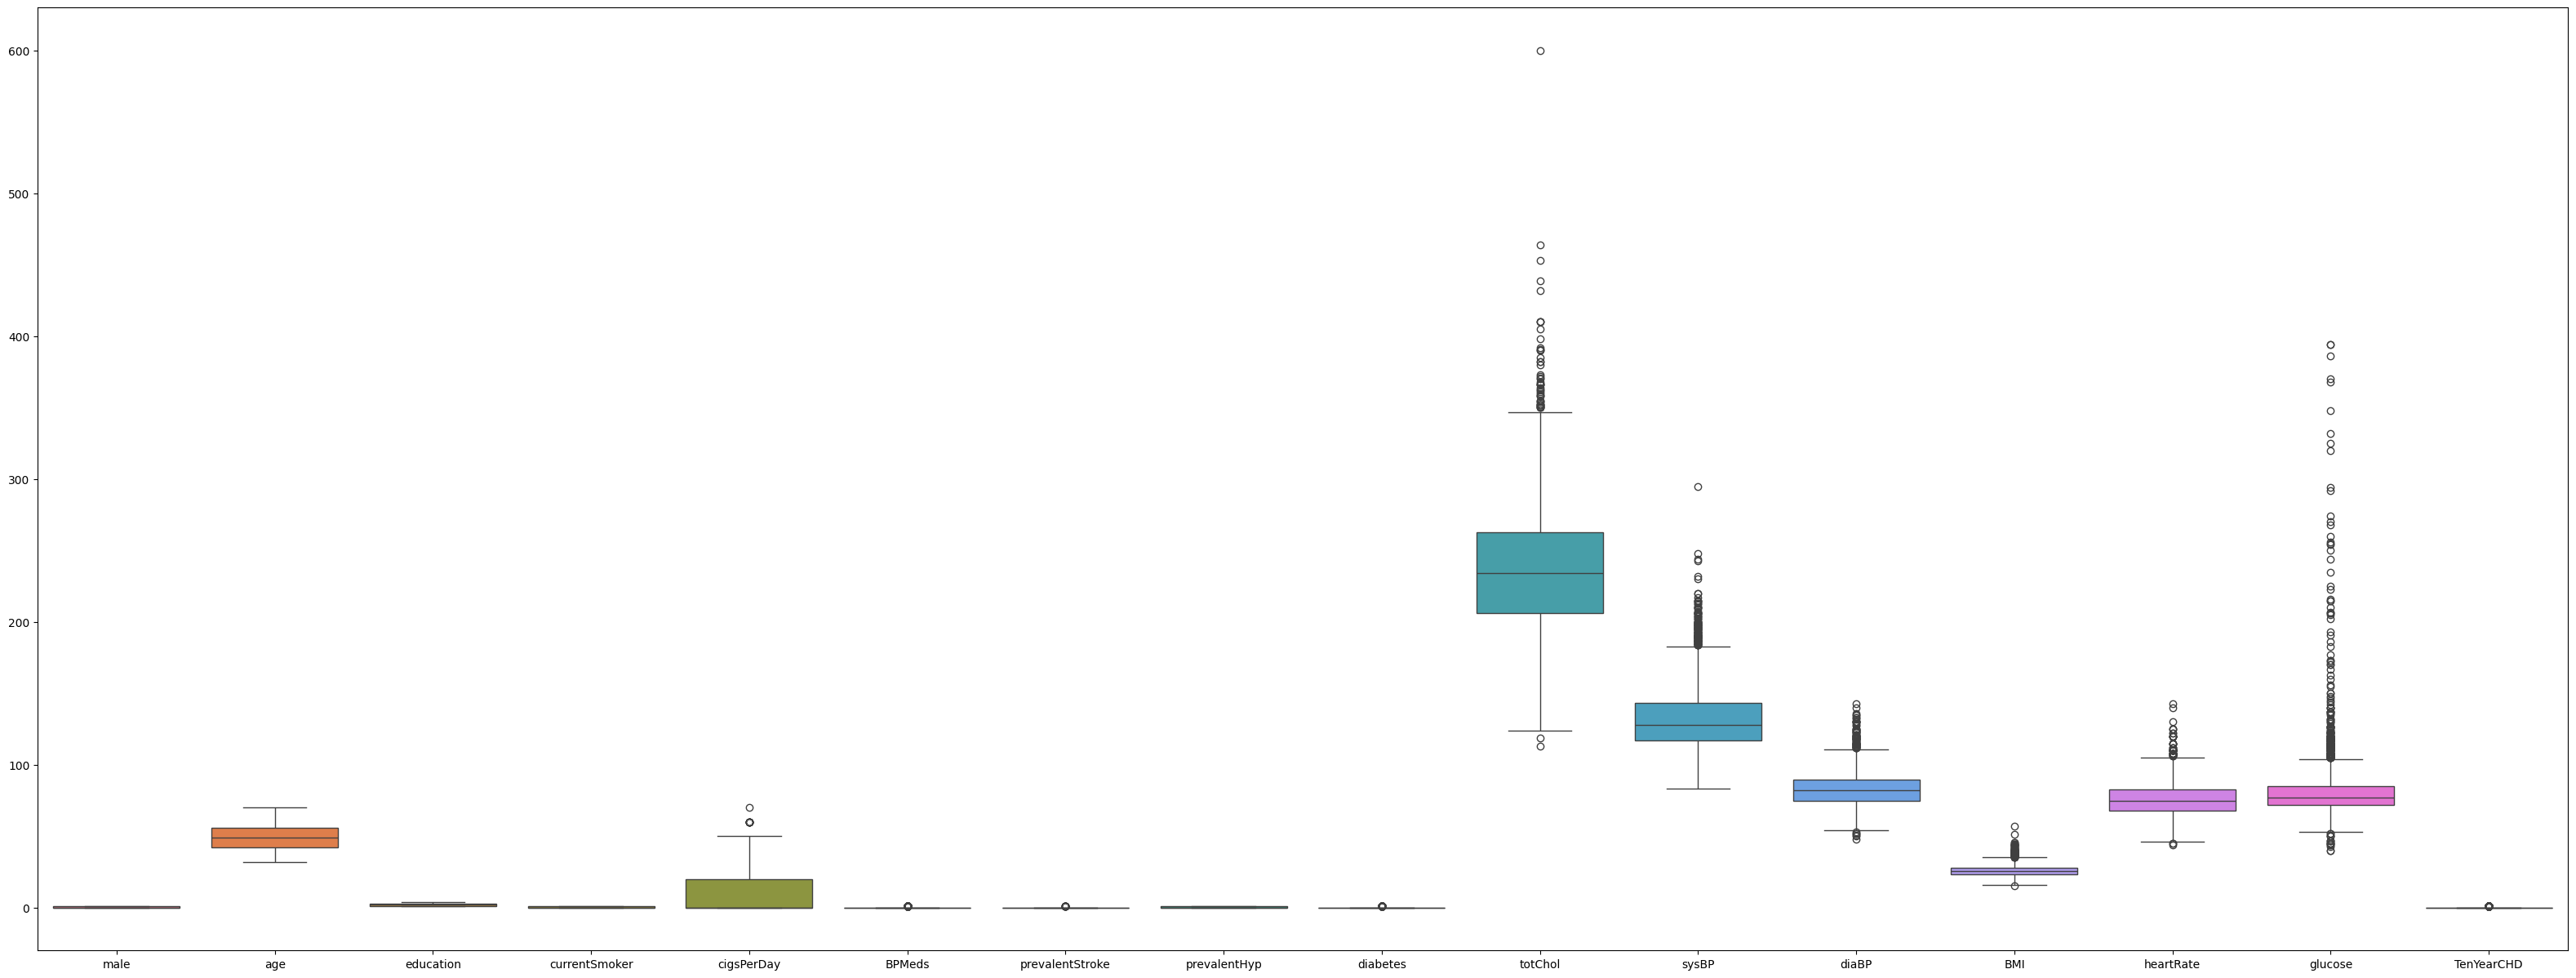

In [20]:
plt.figure(figsize=(40,15), facecolor='w')
sns.boxplot(data=df_data)
plt.show()

In [21]:
df_data['totChol'].max()

600.0

In [22]:
df_data['sysBP'].max()

295.0

In [23]:
df_data = df_data[df_data['totChol']<600.0]
df_data = df_data[df_data['sysBP']<295.0]
df_data.shape

(3987, 16)

* Removable Outliers are detected in totChol and sysBP columns of our dataset. Outliers in all other numerical columns are important and thus cannot be removed.
*  the missing values, outliers and duplicate values are dealt with, now we perform EDA.

In [24]:
df_data.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000
mean,0.433409,49.469526,1.982694,0.491347,9.027840,0.029345,0.005518,0.309255,0.025082,236.502132,132.177452,82.849887,25.769488,75.869325,81.272385,0.148733
std,0.495608,8.531325,1.020832,0.499988,11.918332,0.168794,0.074087,0.462244,0.156392,43.653337,21.793408,11.854644,4.075145,12.086398,22.954842,0.355870
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.060000,68.000000,72.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.380000,75.000000,77.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,143.000000,89.500000,27.990000,83.000000,85.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,464.000000,248.000000,142.500000,56.800000,143.000000,394.000000,1.000000


Continuos value features analysis:

* Age : We can see that Min. age of subject found in given records is 32 while Max. being 70. So our values are ranging from 32 to 70.
* cigsPerDay : Subject smoking Cig. per day is as low as nill while we have 70 Cigs. per day making the Peak.
* totChol : Min. Cholesterol level recorded in our dataset is 107 while Max. is 696.
* sysBP : Min. Systolic Blood Pressure observed in Subject is 83 while Max. is 295.
* diaBP : Min. Diastolic Blood Pressure observed in Subject is 48 while Max. is 142.
* BMI : Body Mass Index in our dataset ranges from 15.54 to 57 .
* heartRate : Observed Heartrate in our case study is 44 to 143.
* glucose : Glucose sugar level range is 40 to 394.

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
male,1.000000,-0.022271,0.012846,0.200413,0.325378,-0.050109,-0.003655,0.008331,0.018317,-0.067404,-0.031767,0.060054,0.080171,-0.115686,0.009070,0.092442
age,-0.022271,1.000000,-0.160758,-0.213310,-0.190319,0.128583,0.045118,0.304031,0.104931,0.271461,0.389472,0.204822,0.133489,-0.008925,0.116007,0.228941
education,0.012846,-0.160758,1.000000,0.018139,0.006329,-0.010156,-0.028592,-0.081164,-0.034995,-0.023309,-0.127374,-0.062408,-0.135678,-0.057808,-0.031328,-0.053684
currentSmoker,0.200413,-0.213310,0.018139,1.000000,0.770796,-0.049012,-0.032574,-0.105110,-0.038933,-0.047181,-0.129719,-0.108840,-0.164294,0.052682,-0.051469,0.023450
cigsPerDay,0.325378,-0.190319,0.006329,0.770796,1.000000,-0.044054,-0.033985,-0.066410,-0.035235,-0.024983,-0.086929,-0.050388,-0.087239,0.068342,-0.050903,0.060126
BPMeds,-0.050109,0.128583,-0.010156,-0.049012,-0.044054,1.000000,0.127479,0.259859,0.048140,0.087307,0.262652,0.196724,0.103322,0.016391,0.054397,0.090205
prevalentStroke,-0.003655,0.045118,-0.028592,-0.032574,-0.033985,0.127479,1.000000,0.067370,0.009705,0.008219,0.055719,0.049504,0.031511,-0.012082,0.016523,0.044988
prevalentHyp,0.008331,0.304031,-0.081164,-0.105110,-0.066410,0.259859,0.067370,1.000000,0.073136,0.163205,0.695979,0.615394,0.303619,0.150751,0.083679,0.174795
diabetes,0.018317,0.104931,-0.034995,-0.038933,-0.035235,0.048140,0.009705,0.073136,1.000000,0.032146,0.100603,0.050340,0.082461,0.051506,0.608596,0.086217
totChol,-0.067404,0.271461,-0.023309,-0.047181,-0.024983,0.087307,0.008219,0.163205,0.032146,1.000000,0.214626,0.171085,0.122846,0.088668,0.044419,0.078166


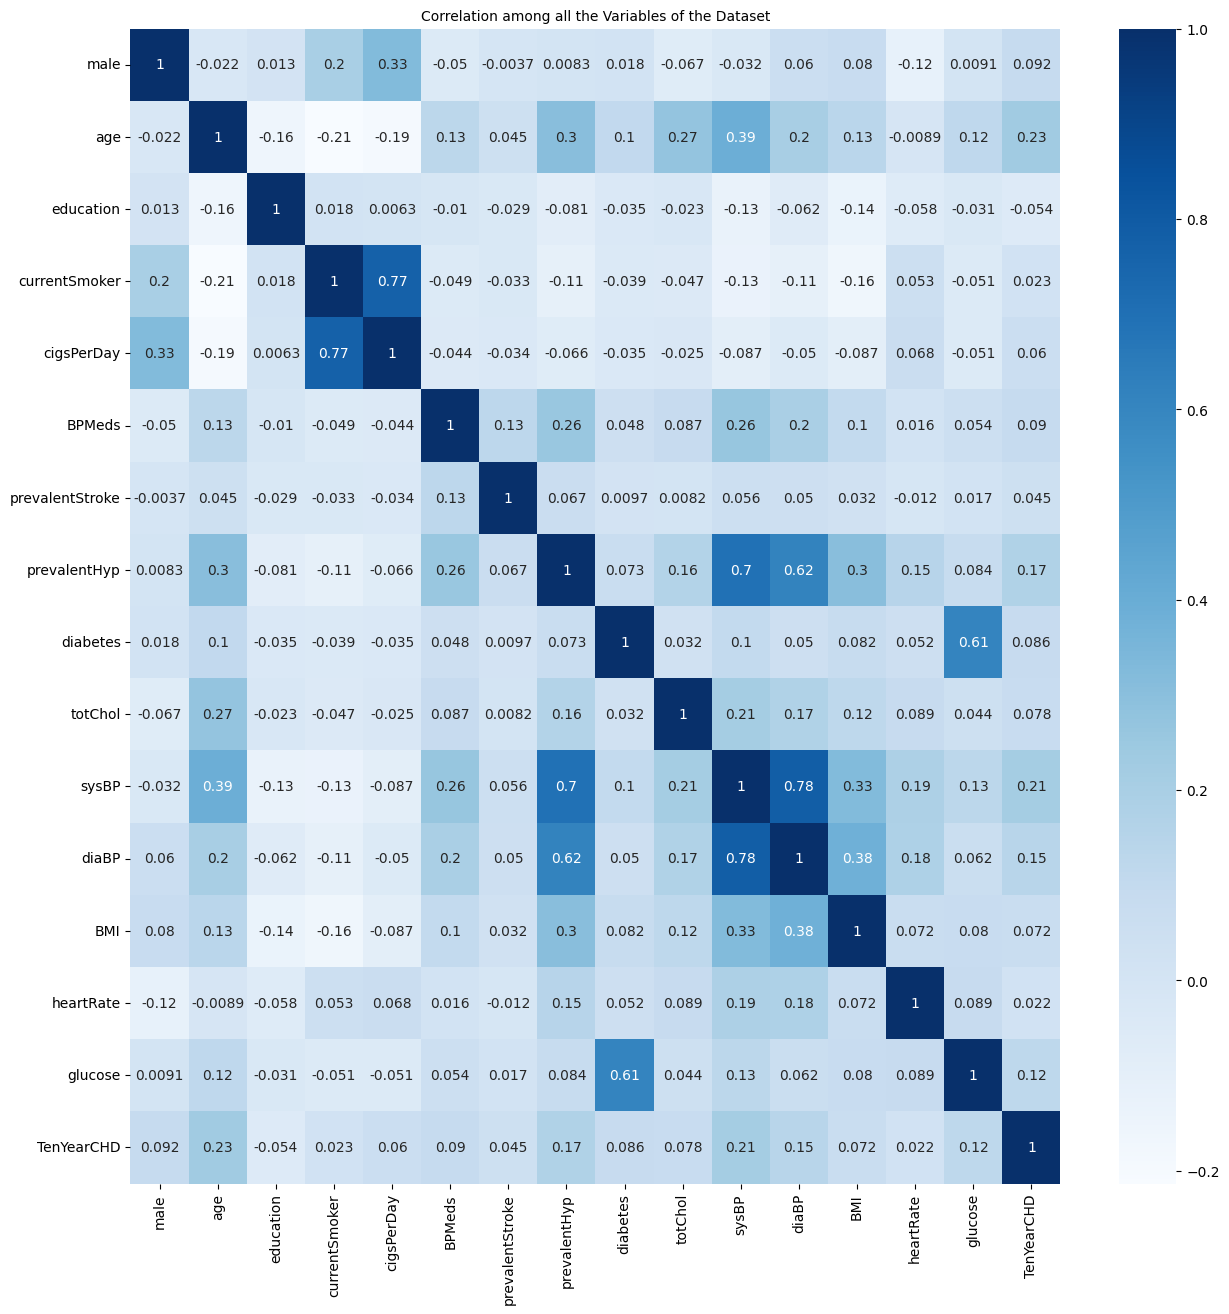

In [25]:
#Checking relationship between variables
cor=df_data.corr()
plt.figure(figsize=(15,15), facecolor='w')
sns.heatmap(cor,xticklabels=cor.columns,yticklabels=cor.columns,annot=True, cmap ='Blues' )
plt.title("Correlation among all the Variables of the Dataset", size=10)
cor

The Pearson correlation between the attributes provides information to deduce if a feature is usefull or not.

* currentSmoker and cigsPerDay has a strong Correlation of 77.
* prevalentHyp vs sysBP / diaBP are having Positive Correlation of 70 and 62.
* glucose and diabetes are postively Correlated alongside sysBP and diaBP.
* The column education has a negative correlatio with the outcom variable 'TenYearCHD'. In practicality distinguishing between patients by using a feature such an education will be subjective and will not effect the prediction.

## Univariate Analysis

In [26]:
categorical_features = ['age', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

In [27]:
for feature in categorical_features:
    print(feature,':')
    print(df_data[feature].value_counts())
    print("-----------------")

age :
age
40    181
46    179
42    173
41    165
48    163
39    162
44    159
43    154
45    152
52    138
38    137
51    136
53    134
55    134
50    131
54    129
47    127
49    124
56    114
57    113
59    112
58    108
60    105
63    104
61     98
62     95
37     86
64     83
36     82
65     51
67     39
35     39
66     35
68     16
34     16
69      6
33      5
32      1
70      1
Name: count, dtype: int64
-----------------
education :
education
1.0    1653
2.0    1209
3.0     666
4.0     459
Name: count, dtype: int64
-----------------
currentSmoker :
currentSmoker
0    2028
1    1959
Name: count, dtype: int64
-----------------
BPMeds :
BPMeds
0.0    3870
1.0     117
Name: count, dtype: int64
-----------------
prevalentStroke :
prevalentStroke
0    3965
1      22
Name: count, dtype: int64
-----------------
prevalentHyp :
prevalentHyp
0    2754
1    1233
Name: count, dtype: int64
-----------------
diabetes :
diabetes
0    3887
1     100
Name: count, dtype: int64
--------

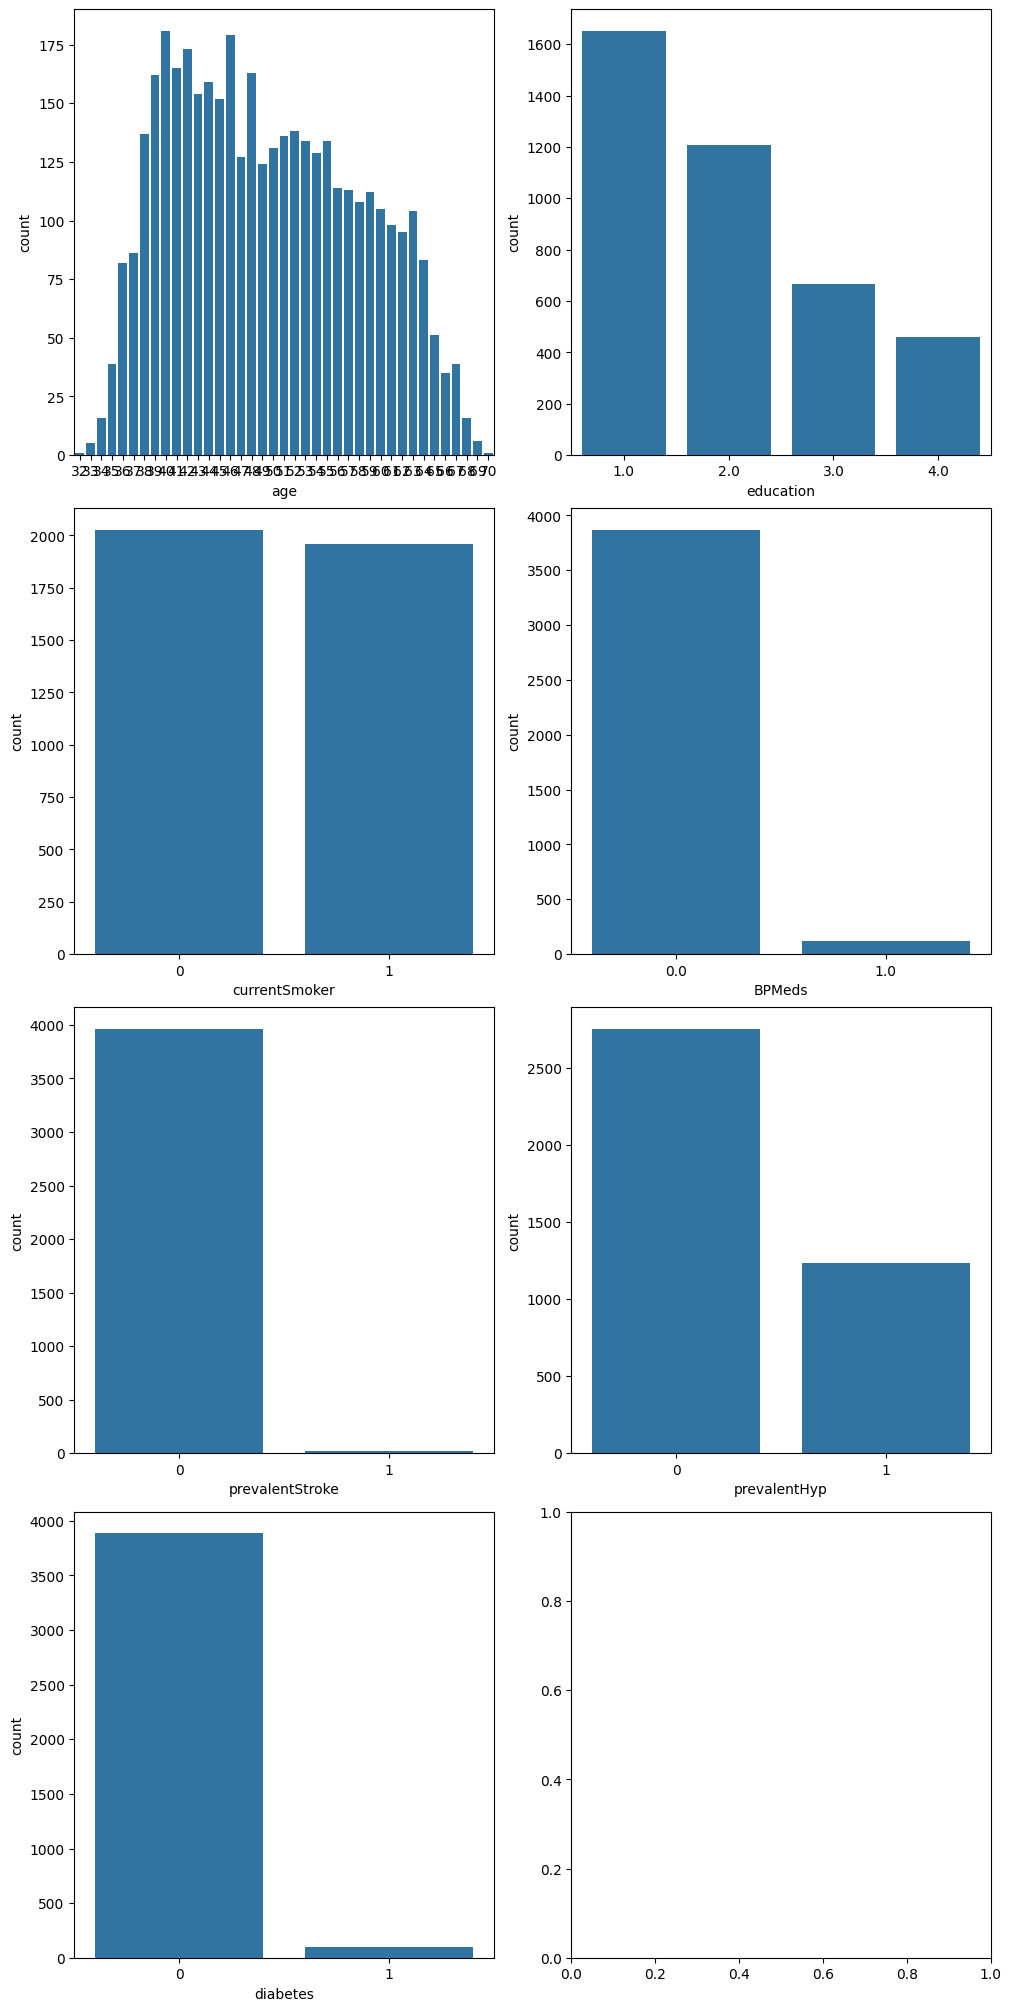

In [28]:
num_plots = len(categorical_features)
total_cols = 2
total_rows = num_plots//total_cols + 1
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(5*total_cols, 5*total_rows), facecolor='w', constrained_layout=True)
for i, var in enumerate(categorical_features):
    row = i//total_cols
    pos = i % total_cols
    plot = sns.countplot(x=var, data=df_data, ax=axs[row][pos])

Among the categorical features:
* BPmeds, prevalentStroke and diabetes are highly imbalanced.
* BPMeds, currentSmoker, diabetes, male, prevalentHyp, and prevalentStroke are binary variable features of the dataset.
* The number of Smokers and non-Smokers in currentSmoker is almost the same

<ipython-input-29-3d50fd6fc075>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_data['glucose'] , color='blue')
<ipython-input-29-3d50fd6fc075>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_data['totChol'], color='orange')
<ipython-input-29-3d50fd6fc075>:14: UserWarning: 

`distplot` 

Text(0.5, 1.0, 'Distribution of HeartRate')

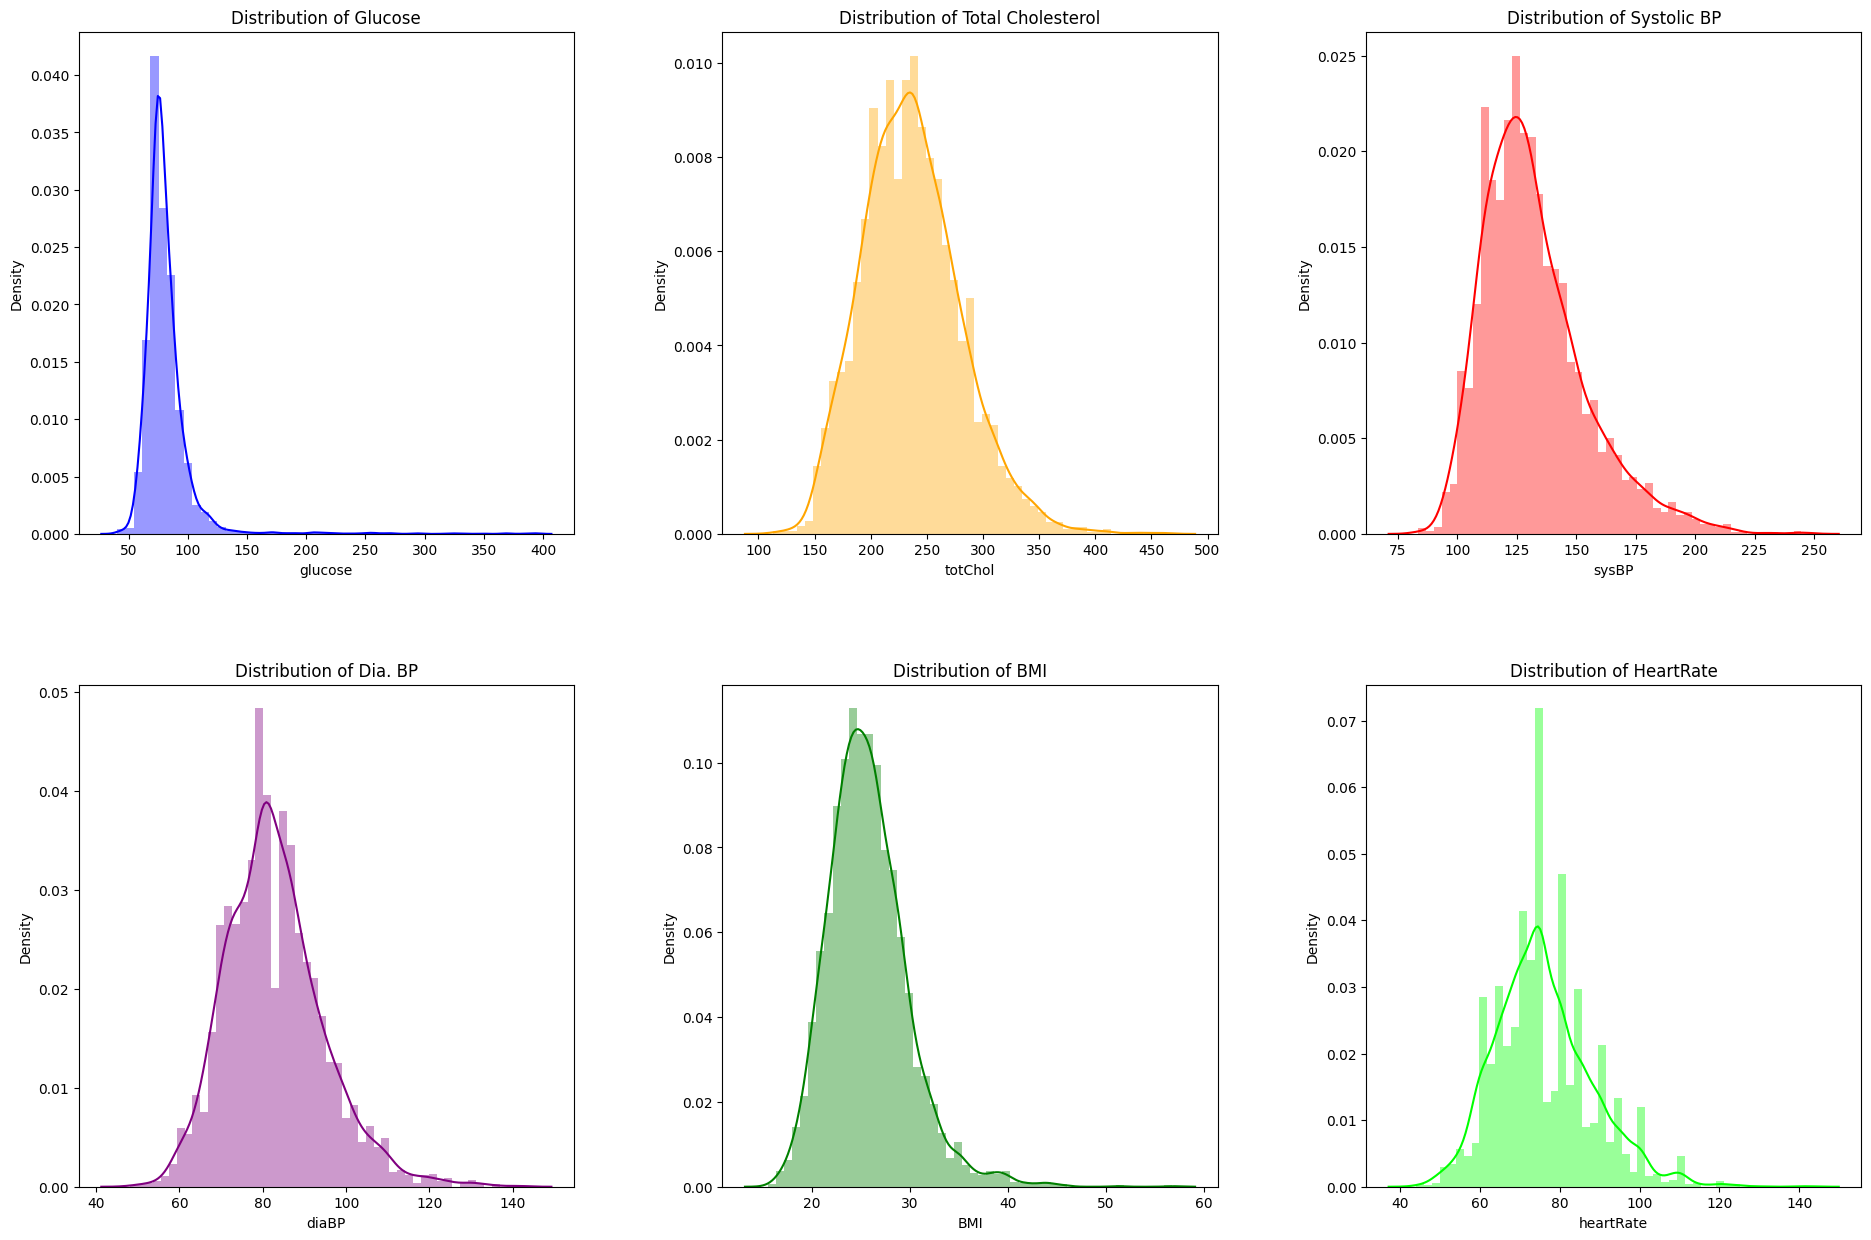

In [29]:
#numeric_features
plt.figure(figsize=(23,15))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(2, 3, 1)
sns.distplot(df_data['glucose'] , color='blue')
plt.title('Distribution of Glucose')

plt.subplot(2, 3, 2)
sns.distplot(df_data['totChol'], color='orange')
plt.title('Distribution of Total Cholesterol')

plt.subplot(2, 3, 3)
sns.distplot(df_data['sysBP'], color='r')
plt.title('Distribution of Systolic BP')

plt.subplot(2, 3, 4)
sns.distplot(df_data['diaBP'] , color='purple')
plt.title('Distribution of Dia. BP')

plt.subplot(2, 3, 5)
sns.distplot(df_data['BMI'], color='g')
plt.title('Distribution of BMI')

plt.subplot(2, 3, 6)
sns.distplot(df_data['heartRate'], color='lime')
plt.title('Distribution of HeartRate')

* Glucose, Total Cholestrol, SysBP, and BMI are right skewed.
* DiaBP and HeartRate are almost close to normal distibution.

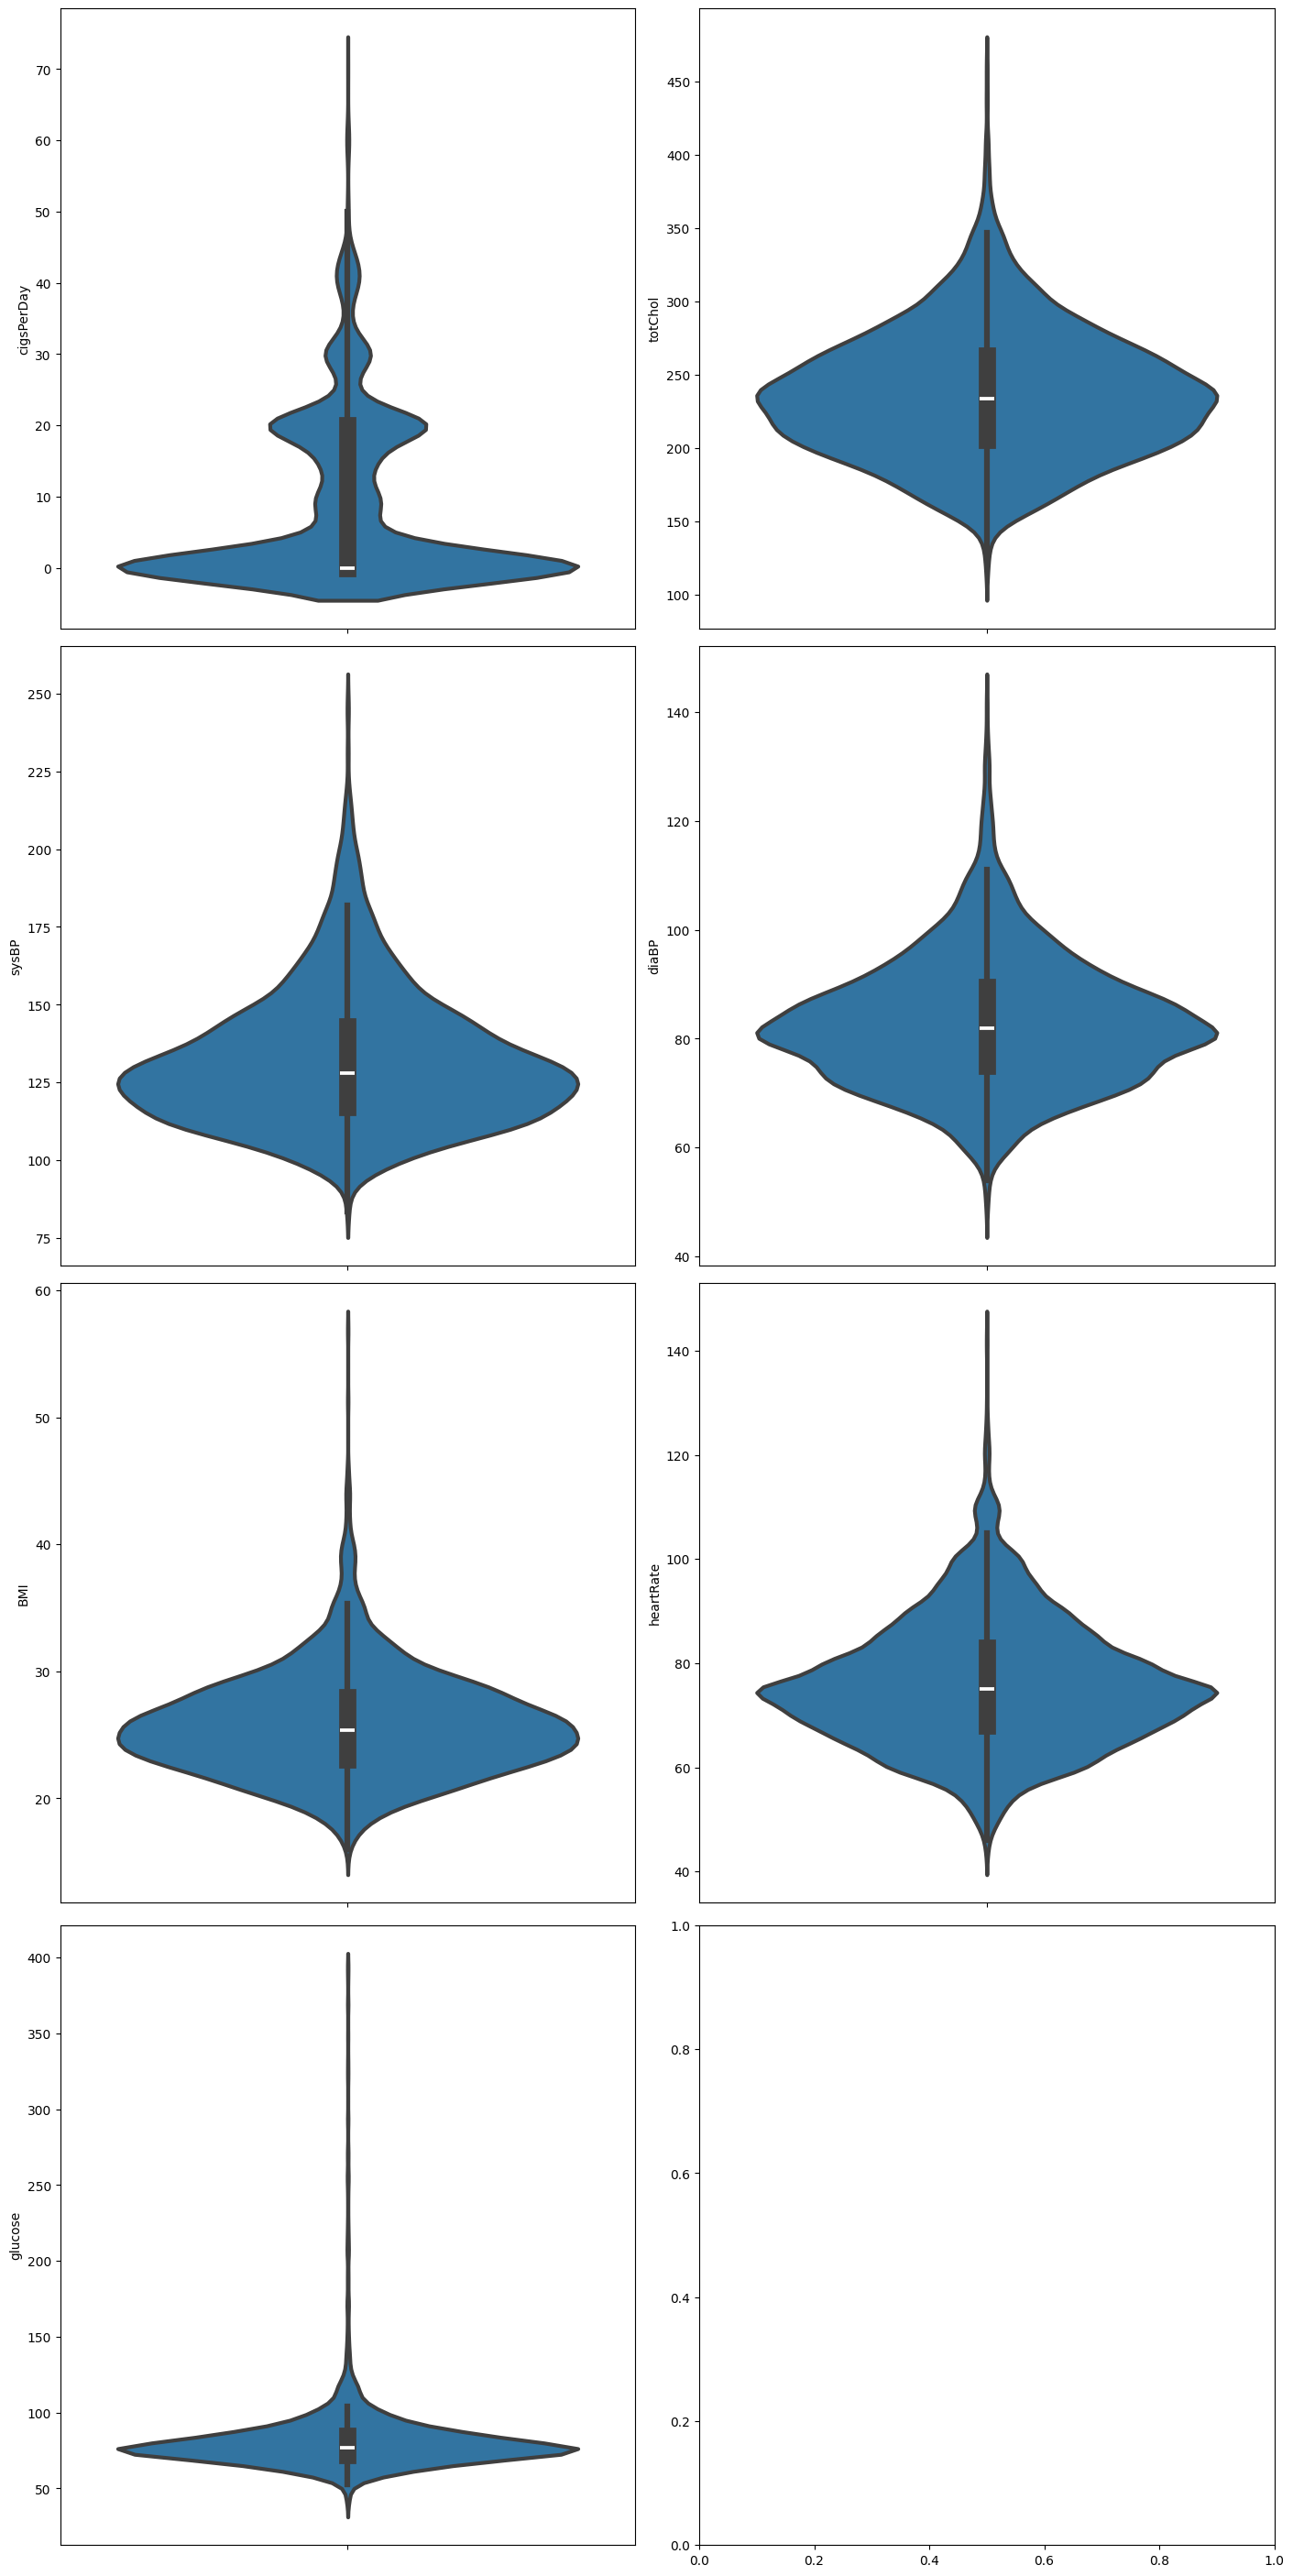

In [30]:
numeric_features = ['cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
num_plots = len(numeric_features)
total_cols = 2
total_rows = num_plots//total_cols + 1
color = ['v', 'i', 'b', 'g', 'y', 'o', 'r']
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(7*total_cols, 7*total_rows), facecolor='w', constrained_layout=True)
for i, var in enumerate(numeric_features):
    row = i//total_cols
    pos = i % total_cols
    plot = sns.violinplot(y=var, data=df_data, ax=axs[row][pos], linewidth=3)

* cigsPerDay has a highly uneven distribution with the most data present in 0.
* The majority portions of the following columns lie in the range:
 * totChol: 150 to 300
 * sysBP: 100 to 150
 * diaBP: 60 to 100
 * BMI: 20 to 30
 * heartRate: 50 to 100
* glucose: 50 to 150

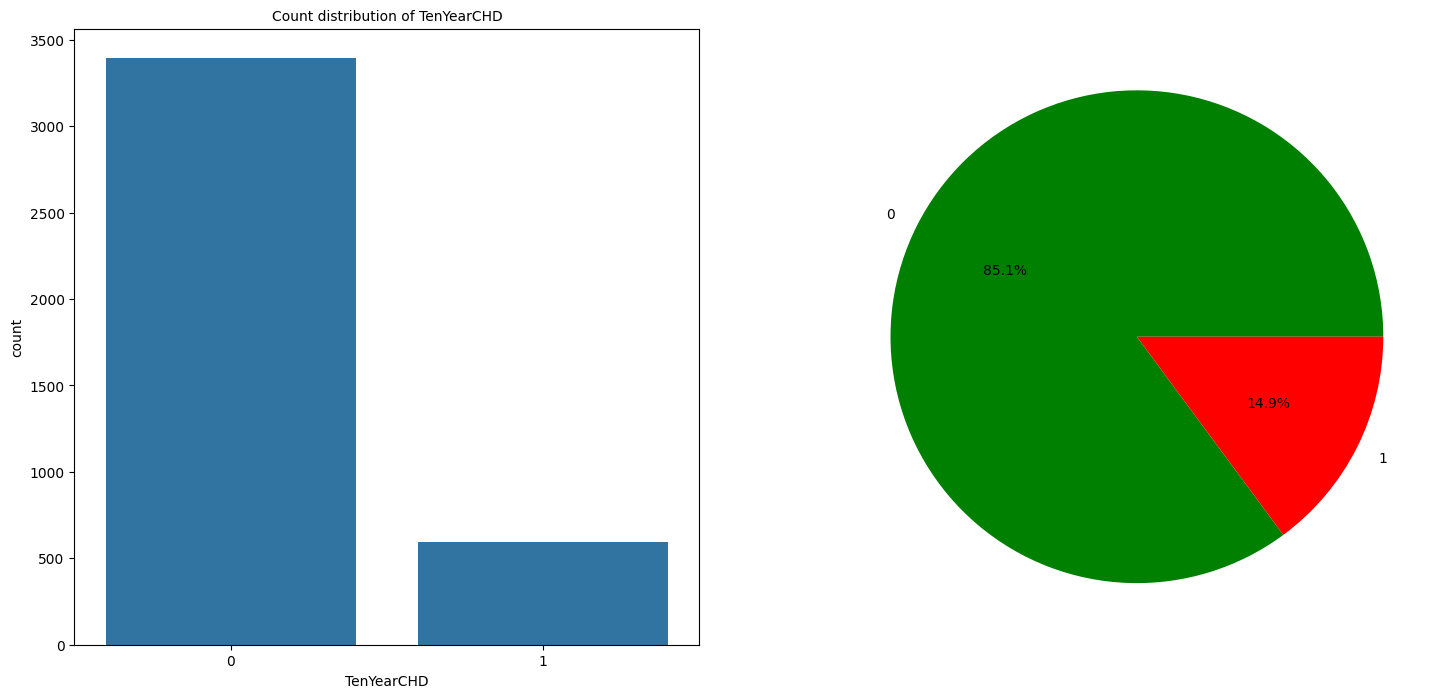

In [31]:
#Target variable
#Distribution of outcome variable, Heart Disease
plt.figure(figsize=(10, 8), facecolor='w')
plt.subplots_adjust(right=1.5)
plt.subplot(121)
sns.countplot(x="TenYearCHD", data=df_data)
plt.title("Count distribution of TenYearCHD", size=10)
plt.subplot(122)
labels=[0,1]
plt.pie(df_data["TenYearCHD"].value_counts(),autopct="%1.1f%%",labels=labels,colors=["green","red"])
plt.show()

The distribution is highly imbalanced. As in, the number of negative cases outweigh the number of positive cases.
This would lead to class imbalance problem while fitting our models.
Therefore, this problem needs to be addressed and taken care of.

## Bivariate Analysis

(array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]),
 [Text(0, 4.0, '4'),
  Text(0, 5.0, '5'),
  Text(0, 6.0, '6'),
  Text(0, 7.0, '7'),
  Text(0, 8.0, '8'),
  Text(0, 9.0, '9'),
  Text(0, 10.0, '10'),
  Text(0, 11.0, '11'),
  Text(0, 12.0, '12'),
  Text(0, 13.0, '13')])

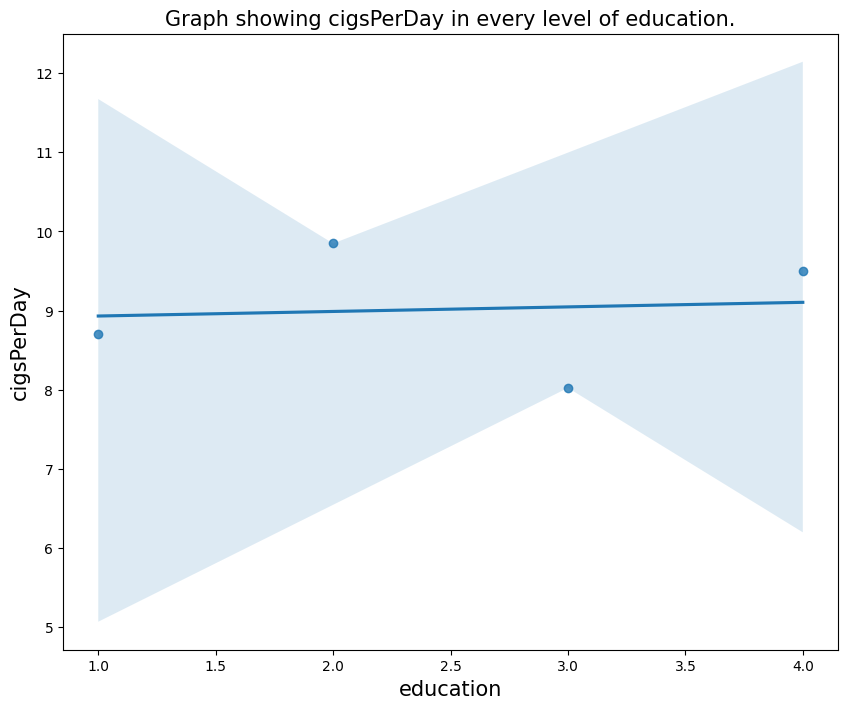

In [32]:
#Relationship between education and cigsPerDay
#Grouping education and cigsPerDay
graph_1 = df_data.groupby("education", as_index=False).cigsPerDay.mean()
plt.figure(figsize=(10,8), facecolor='w')
sns.regplot(x=graph_1["education"], y=graph_1["cigsPerDay"])
plt.title("Graph showing cigsPerDay in every level of education.", size=15)
plt.xlabel("education", size=15)
plt.ylabel("cigsPerDay", size=15)
plt.xticks(size=10)
plt.yticks(size=10)

(array([ 0.,  5., 10., 15., 20., 25., 30., 35.]),
 [Text(0, 0.0, '0'),
  Text(0, 5.0, '5'),
  Text(0, 10.0, '10'),
  Text(0, 15.0, '15'),
  Text(0, 20.0, '20'),
  Text(0, 25.0, '25'),
  Text(0, 30.0, '30'),
  Text(0, 35.0, '35')])

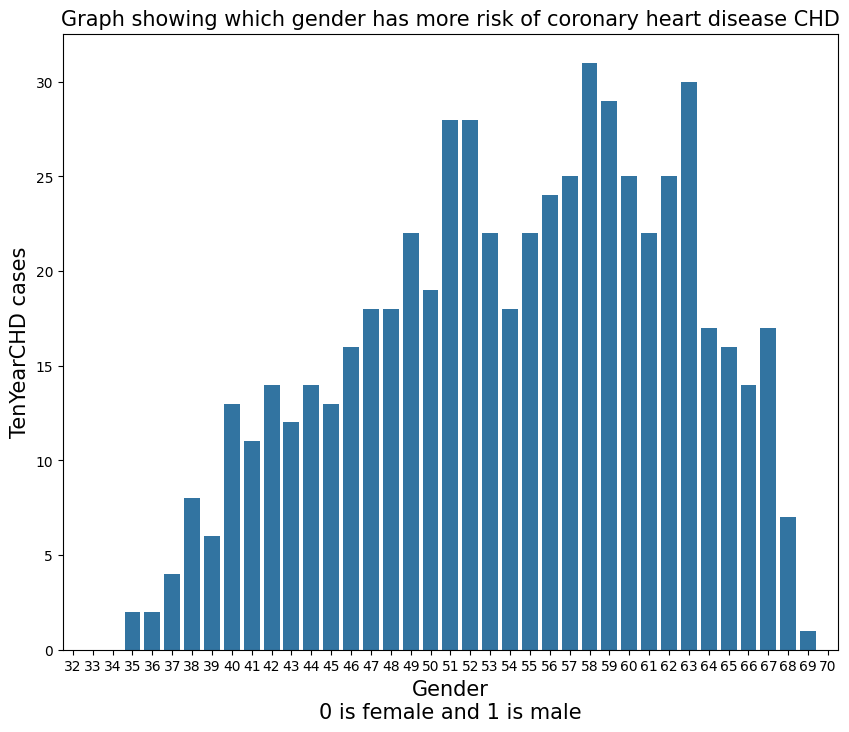

In [33]:
#checking for which gender has more risk of coronary heart disease CHD
graph_2 = df_data.groupby("age", as_index=False).TenYearCHD.sum()
#Ploting the above values
plt.figure(figsize=(10,8), facecolor='w')
sns.barplot(x=graph_2["age"], y=graph_2["TenYearCHD"])
plt.title("Graph showing which gender has more risk of coronary heart disease CHD", size=15)
plt.xlabel("Gender\n0 is female and 1 is male",size=15)
plt.ylabel("TenYearCHD cases", size=15)
plt.xticks(size=10)
plt.yticks(size=10)

According to this dataset, males have shown a slighly higher risk of coronary heart disease TenYearCHD.

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120'),
  Text(0, 140.0, '140')])

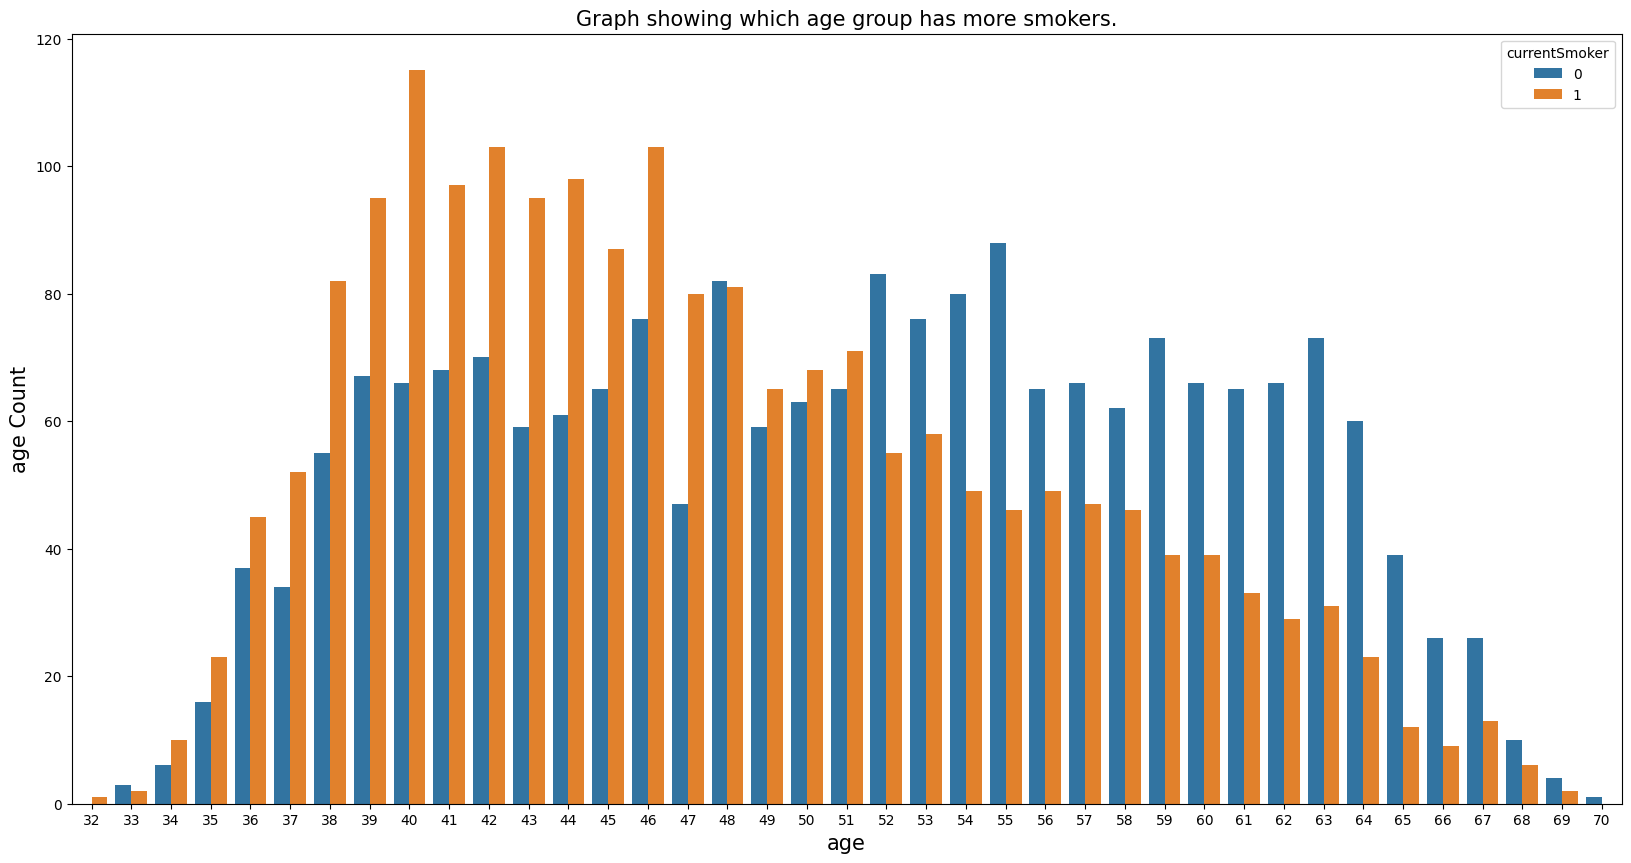

In [34]:
#Distribution of current smokers with respect to age
plt.figure(figsize=(20,10), facecolor='w')
sns.countplot(x="age",data=df_data,hue="currentSmoker")
plt.title("Graph showing which age group has more smokers.", size=15)
plt.xlabel("age", size=15)
plt.ylabel("age Count", size=15)
plt.xticks(size=10)
plt.yticks(size=10)

* Mid-age groups ranging from the age of 38 - 46 have more number of currentSmokers.
* No currentSmokers observed below the age of 32.
* maximum age for a currentSmokers is 70.

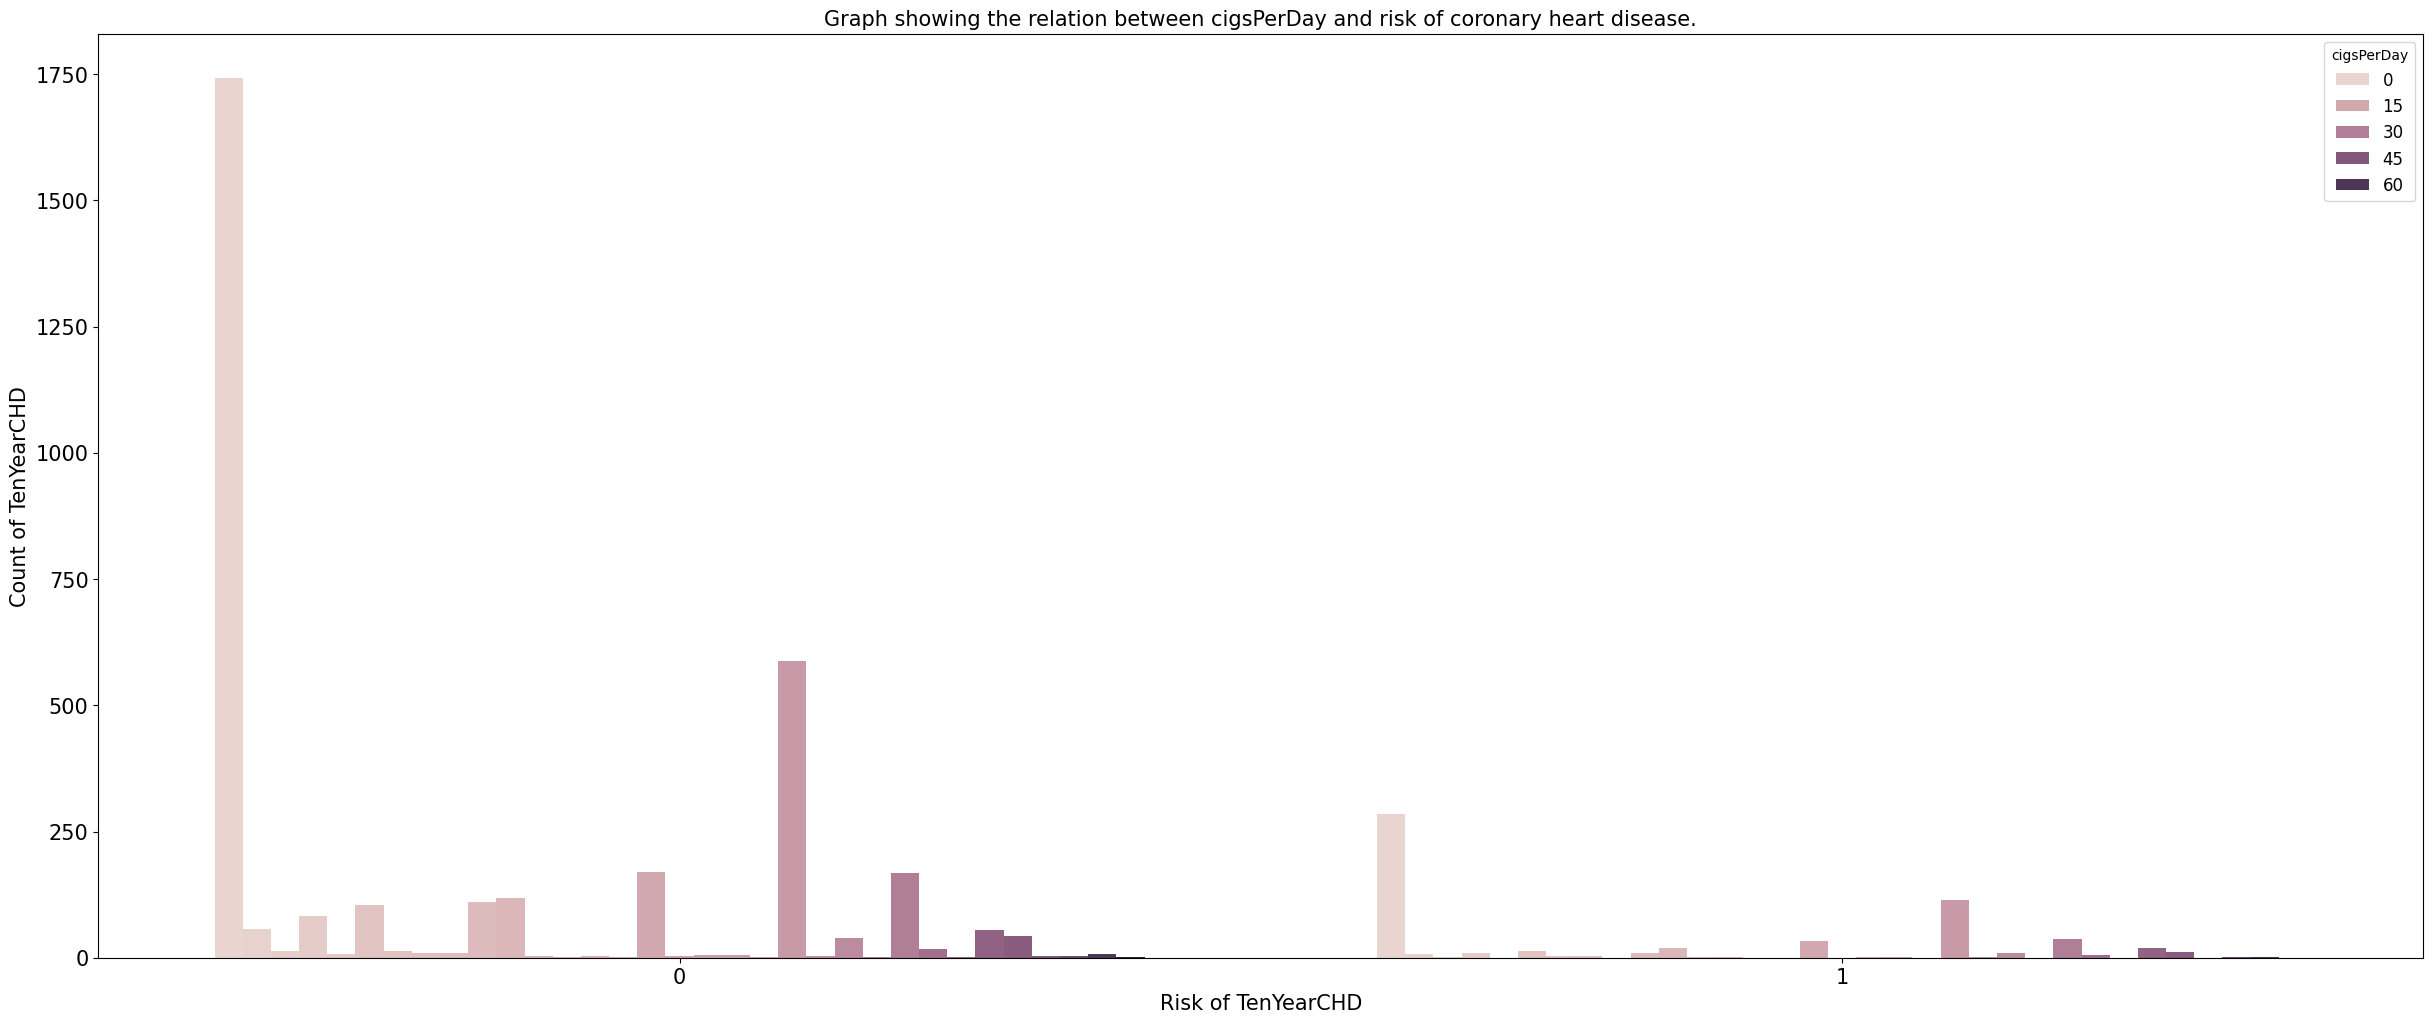

In [35]:
#Relation between cigsPerDay and risk of coronary heart disease.
plt.figure(figsize=(30,12), facecolor='w')
sns.countplot(x="TenYearCHD",data=df_data,hue="cigsPerDay")
plt.legend(title='cigsPerDay', fontsize='large')
plt.title("Graph showing the relation between cigsPerDay and risk of coronary heart disease.", size=15)
plt.xlabel("Risk of TenYearCHD", size=15)
plt.ylabel("Count of TenYearCHD", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

* Low cigsPerDay comes with lower risk of CHD.
* Those who don't smoke, i.e., with a cigsPerDay of 0.0 has a really low risk of contracting the disease
* Although that is the case, low cigsPerDay doesn't actually guarantee a much lower risk of CHD

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120'),
  Text(0, 140.0, '140'),
  Text(0, 160.0, '160')])

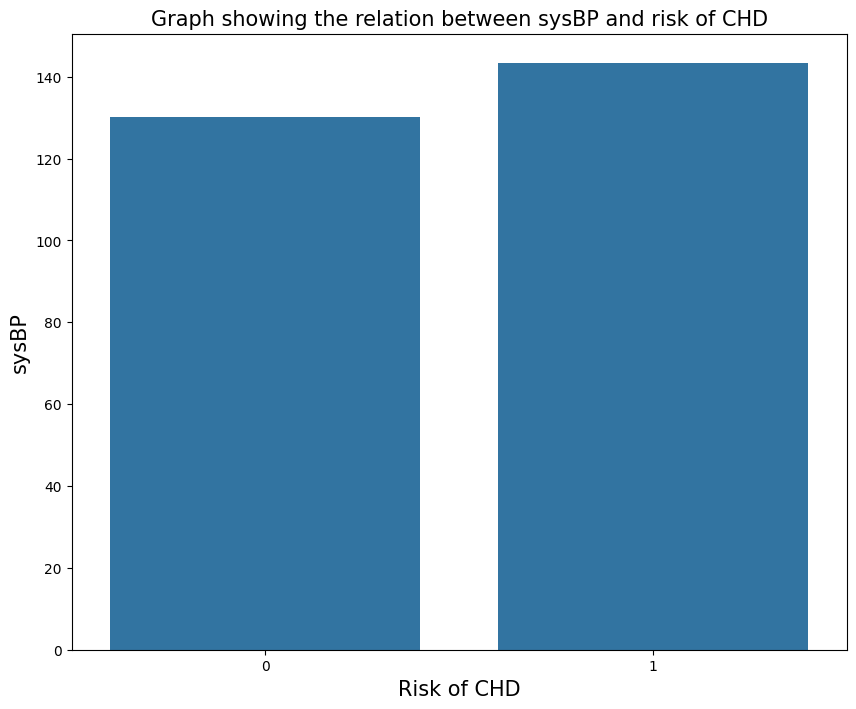

In [36]:
#Relation between sysBP and risk of CHD
# Grouping up the data and ploting it
graph_3 = df_data.groupby("TenYearCHD", as_index=False).sysBP.mean()

plt.figure(figsize=(10,8), facecolor='w')
sns.barplot(x=graph_3["TenYearCHD"], y=graph_3["sysBP"])
plt.title("Graph showing the relation between sysBP and risk of CHD", size=15)
plt.xlabel("Risk of CHD", size=15)
plt.ylabel("sysBP", size=15)
plt.xticks(size=10)
plt.yticks(size=10)

(array([ 60.,  70.,  80.,  90., 100., 110., 120., 130., 140., 150.]),
 [Text(0, 60.0, '60'),
  Text(0, 70.0, '70'),
  Text(0, 80.0, '80'),
  Text(0, 90.0, '90'),
  Text(0, 100.0, '100'),
  Text(0, 110.0, '110'),
  Text(0, 120.0, '120'),
  Text(0, 130.0, '130'),
  Text(0, 140.0, '140'),
  Text(0, 150.0, '150')])

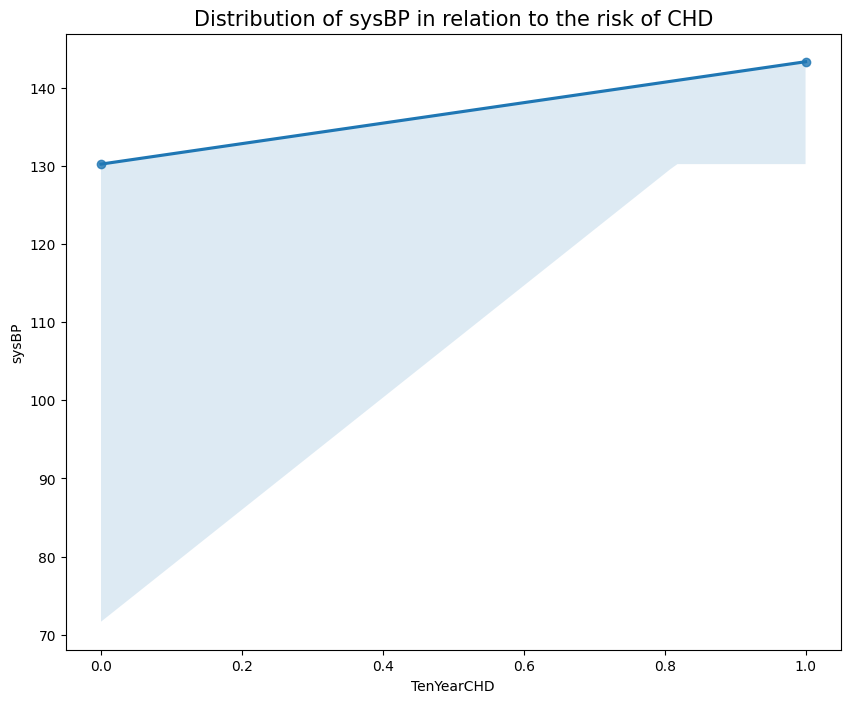

In [37]:
plt.figure(figsize=(10,8), facecolor='w')
sns.regplot(x=graph_3["TenYearCHD"], y=graph_3["sysBP"])
plt.title("Distribution of sysBP in relation to the risk of CHD", size=15)
plt.xticks(size=10)
plt.yticks(size=10)

* Minor relation of higher risk of TenYearCHD found with higher sysBP
* Majority of people with sysBP ranging from 72 - 130 has lower chance of contracting the disease.

(array([  0.,  20.,  40.,  60.,  80., 100.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100')])

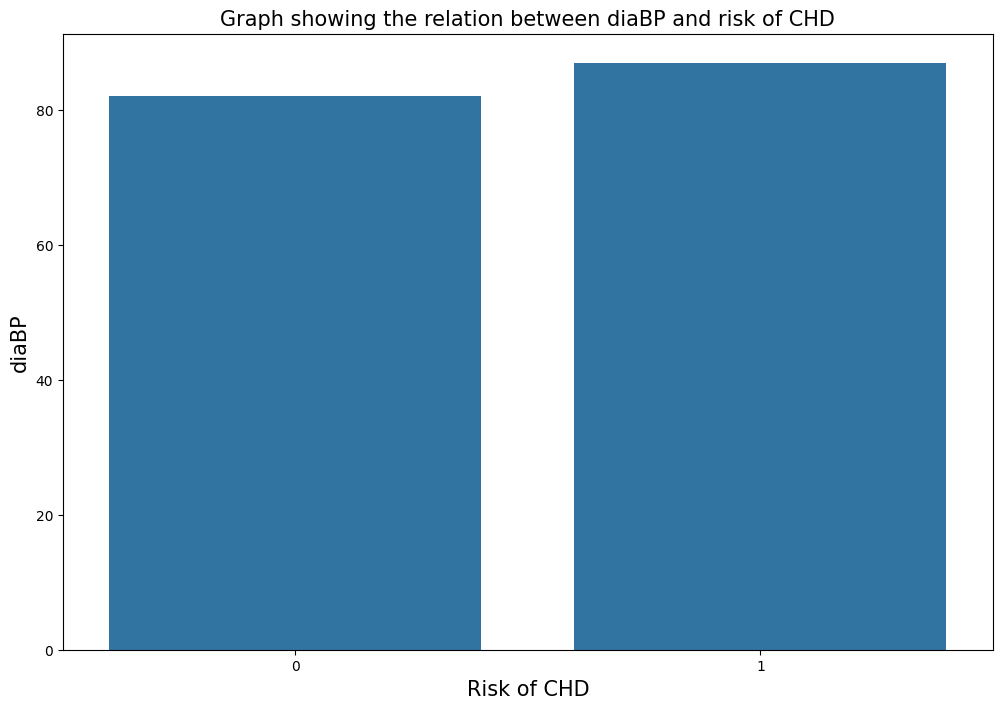

In [38]:
# Grouping up the data and ploting it
# Relation between diaBP and risk of CHD
graph_4 = df_data.groupby("TenYearCHD", as_index=False).diaBP.mean()

plt.figure(figsize=(12,8), facecolor='w')
sns.barplot(x=graph_4["TenYearCHD"], y=graph_4["diaBP"])
plt.title("Graph showing the relation between diaBP and risk of CHD", size=15)
plt.xlabel("Risk of CHD", size=15)
plt.ylabel("diaBP", size=15)
plt.xticks(size=10)
plt.yticks(size=10)

(array([40., 50., 60., 70., 80., 90.]),
 [Text(0, 40.0, '40'),
  Text(0, 50.0, '50'),
  Text(0, 60.0, '60'),
  Text(0, 70.0, '70'),
  Text(0, 80.0, '80'),
  Text(0, 90.0, '90')])

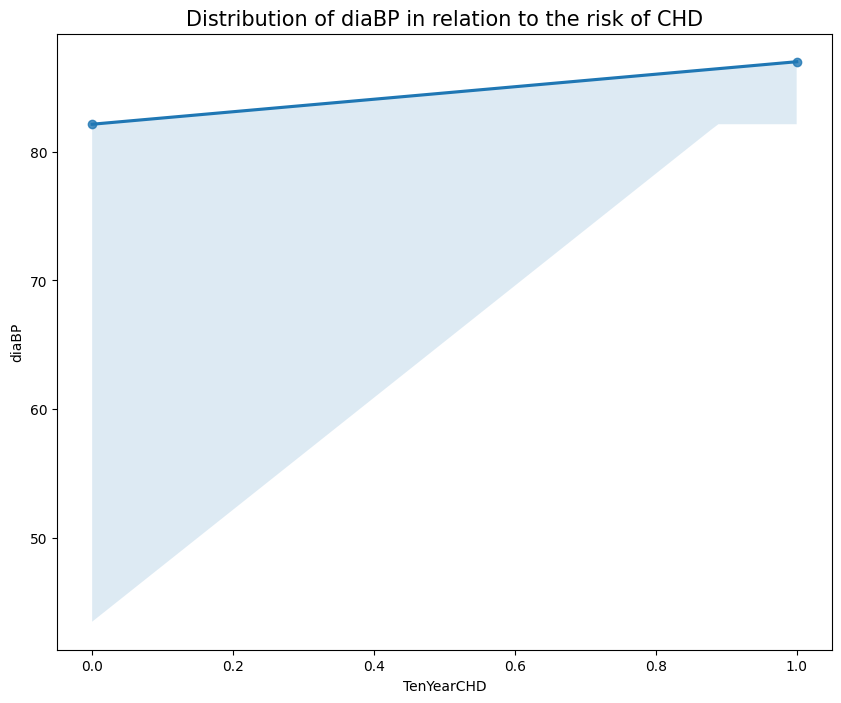

In [39]:
plt.figure(figsize=(10,8), facecolor='w')
sns.regplot(x=graph_4["TenYearCHD"], y=graph_4["diaBP"])
plt.title("Distribution of diaBP in relation to the risk of CHD", size=15)
plt.xticks(size=10)
plt.yticks(size=10)

* Minor relation found between higher risk of TenYearCHD with higher diaBP similar to the previous one
* Majority of people with diaBP ranging upto 80.0 has lower chance of contracting the disease.

(array([  0.,  50., 100., 150., 200., 250., 300.]),
 [Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250'),
  Text(0, 300.0, '300')])

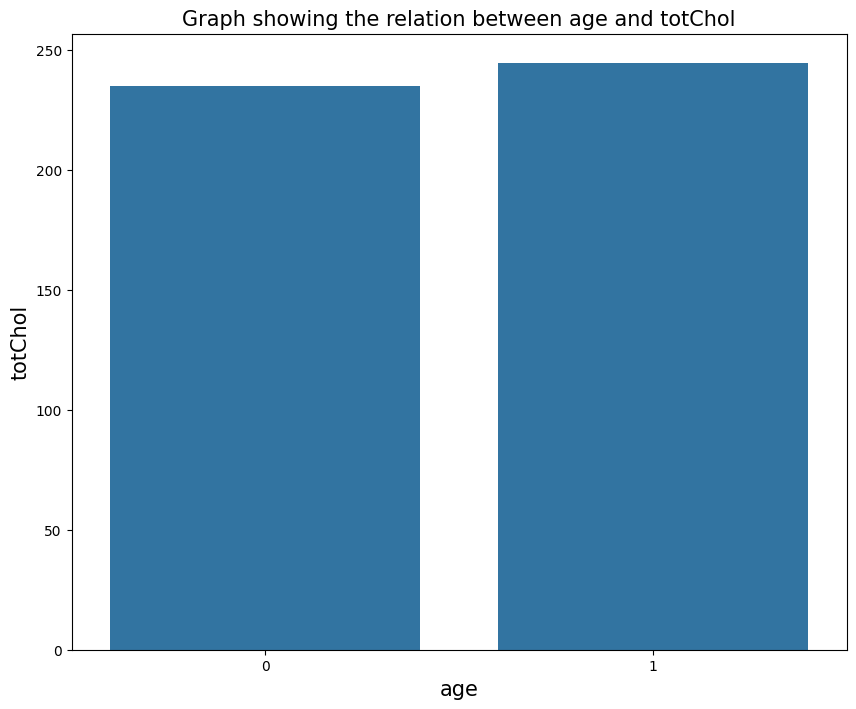

In [40]:
#elation between age and totChol
graph_5 = df_data.groupby("TenYearCHD", as_index=False).totChol.mean()

plt.figure(figsize=(10,8), facecolor='w')
sns.barplot(x=graph_5["TenYearCHD"], y=graph_5["totChol"])
plt.title("Graph showing the relation between age and totChol", size=15)
plt.xlabel("age", size=15)
plt.ylabel("totChol", size=15)
plt.xticks(size=10)
plt.yticks(size=10)

(array([100., 120., 140., 160., 180., 200., 220., 240., 260.]),
 [Text(0, 100.0, '100'),
  Text(0, 120.0, '120'),
  Text(0, 140.0, '140'),
  Text(0, 160.0, '160'),
  Text(0, 180.0, '180'),
  Text(0, 200.0, '200'),
  Text(0, 220.0, '220'),
  Text(0, 240.0, '240'),
  Text(0, 260.0, '260')])

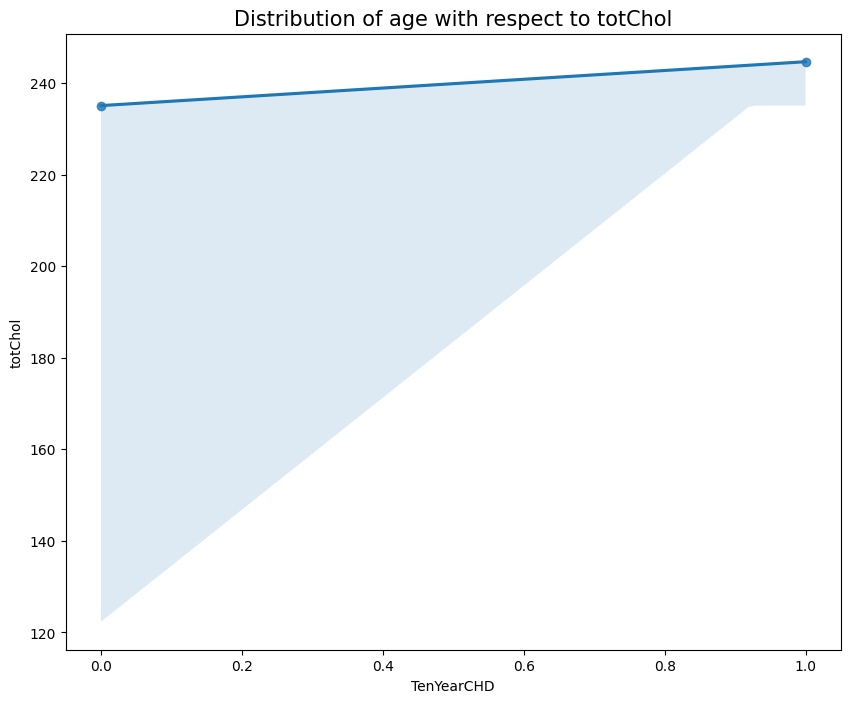

In [41]:
plt.figure(figsize=(10,8), facecolor='w')
sns.regplot(x=graph_5["TenYearCHD"], y=graph_5["totChol"])
plt.title("Distribution of age with respect to totChol", size=15)
plt.xticks(size=10)
plt.yticks(size=10)

* aged people have more cholesterol
* bad cholesterol in general

### Multivariate Analysis

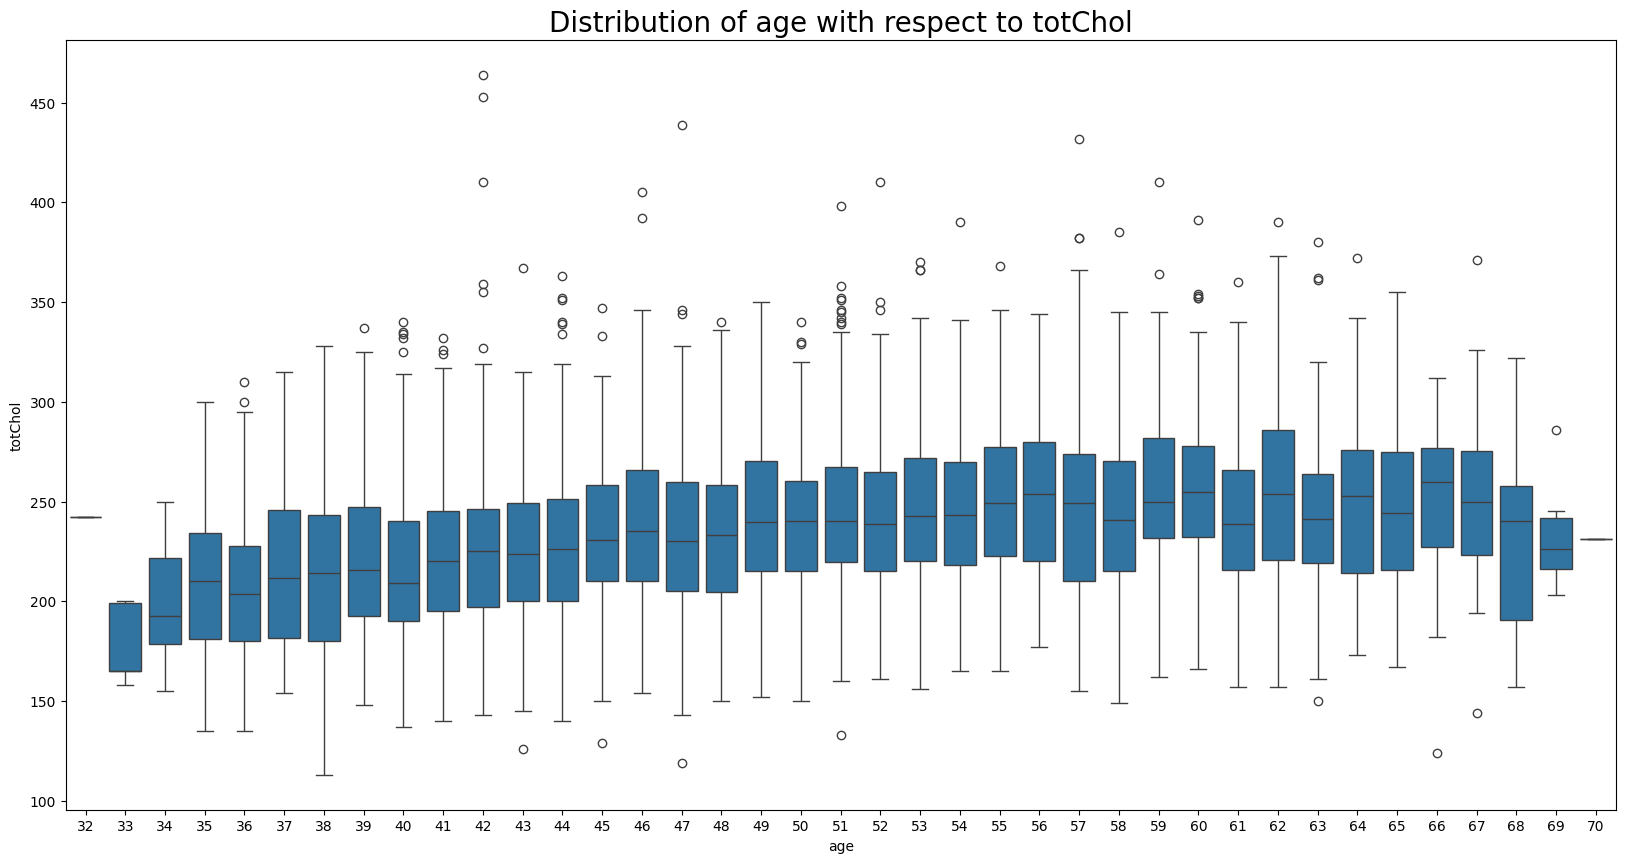

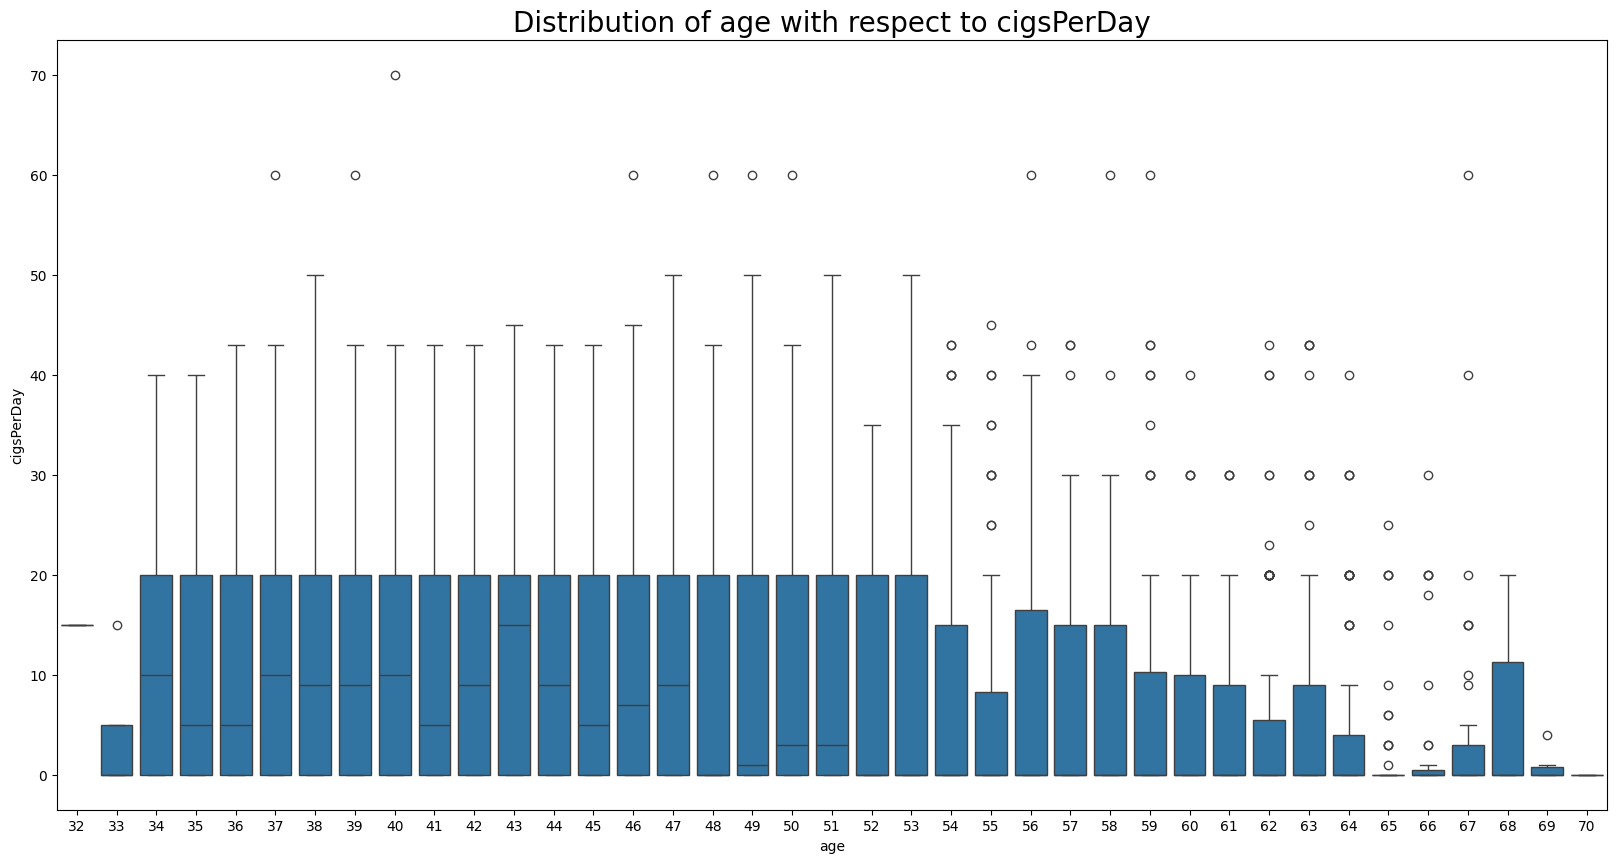

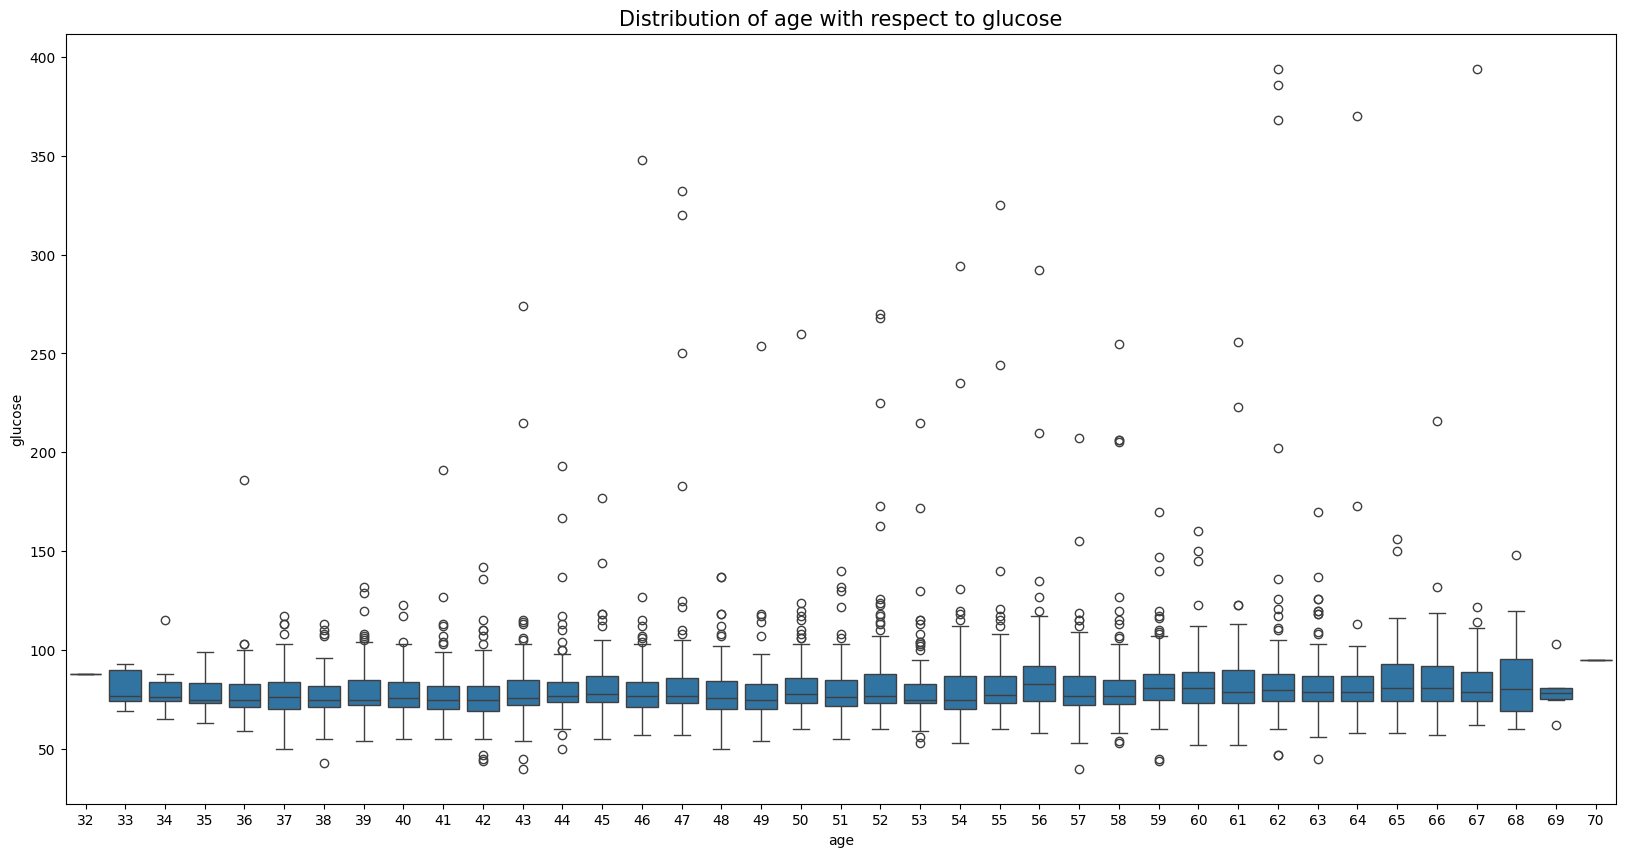

In [42]:
#Relationship between age and cigsPerDay, totChol, glucose.
plt.figure(figsize=(20,10), facecolor='w')
sns.boxplot(x="age",y="totChol",data=df_data)
plt.title("Distribution of age with respect to totChol", size=20)
plt.show()
plt.figure(figsize=(20,10), facecolor='w')
sns.boxplot(x="age",y="cigsPerDay",data=df_data)
plt.title("Distribution of age with respect to cigsPerDay", size=20)
plt.show()
plt.figure(figsize=(20,10), facecolor='w')
sns.boxplot(x="age",y="glucose",data=df_data)
plt.title("Distribution of age with respect to glucose", size=15)
plt.show()

* There is a minor relation between totChol and glucose.
* totChol has a steep, linear and inverse graph for lower ranges of age
* cigsPerDay has a fairly parallel relationship with age

In [43]:
#Distribution of sysBP vs diaBP with respect to currentSmoker and male attributes

#sysBP vs diaBP with respect to currentSmoker and male attributes
plt.figure(figsize=(9, 9), facecolor='w')
sns.lmplot('sysBP', 'diaBP',
           data=df_data,
           hue="TenYearCHD",
           col="age",row="currentSmoker")
plt.show()

TypeError: lmplot() got multiple values for argument 'data'

<Figure size 900x900 with 0 Axes>

The above graph plots the relationship between systolic blood pressure and diastolic blood pressure for patients based on their gender and whether they are current smokers or not and plots the best fit line

## Resampling imbalanced dataset by oversampling positive case

In [44]:
target1=df_data[df_data['TenYearCHD']==1]
target0=df_data[df_data['TenYearCHD']==0]

In [46]:
target1=resample(target1,replace=True,n_samples=len(target0),random_state=40)
target=pd.concat([target0,target1])
target['TenYearCHD'].value_counts()

TenYearCHD
0    3394
1    3394
Name: count, dtype: int64

In [47]:
df_data=target
np.shape(df_data)

(6788, 16)

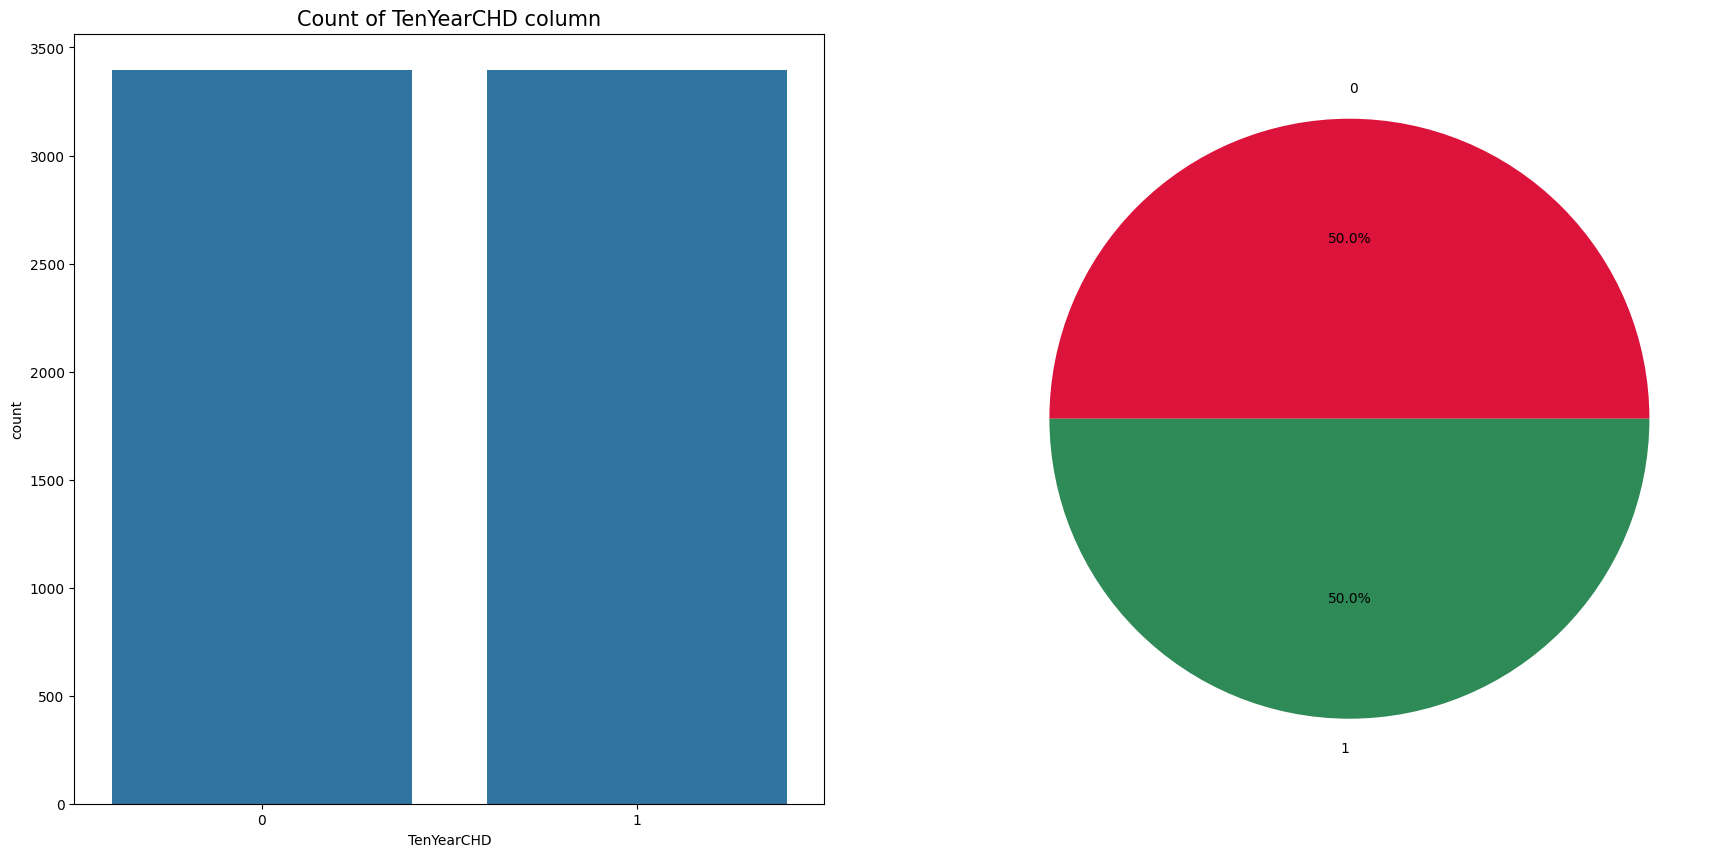

In [48]:
plt.figure(figsize=(12, 10), facecolor='w')
plt.subplots_adjust(right=1.5)
plt.subplot(121)
sns.countplot(x="TenYearCHD", data=df_data)
plt.title("Count of TenYearCHD column", size=15)
plt.subplot(122)
labels=[0,1]
plt.pie(df_data["TenYearCHD"].value_counts(),autopct="%1.1f%%",labels=labels,colors=["crimson","seagreen"])
plt.show()

The number of positive and negative cases are equal.
Hence the classes are now balanced for model fitting

# Feature Selection

In [49]:
X = df_data.iloc[:,0:15]
y = df_data.iloc[:,-1]

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

featureScores = pd.concat([df_columns,df_scores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(11,'Score'))

           Specs        Score
10         sysBP  2372.445197
14       glucose  1356.486145
4     cigsPerDay  1002.861487
1            age   988.892412
9        totChol   980.497134
11         diaBP   592.874948
7   prevalentHyp   227.079395
0           male    77.165763
8       diabetes    67.503759
5         BPMeds    66.216216
12           BMI    42.951746


In [50]:
featureScores = featureScores.sort_values(by='Score', ascending=False)
featureScores


,Specs,Score
10,sysBP,2372.445197
14,glucose,1356.486145
4,cigsPerDay,1002.861487
1,age,988.892412
9,totChol,980.497134
11,diaBP,592.874948
7,prevalentHyp,227.079395
0,male,77.165763
8,diabetes,67.503759
5,BPMeds,66.216216


<ipython-input-51-c95212206710>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Specs', y='Score', data=featureScores, palette = "Blues_r")


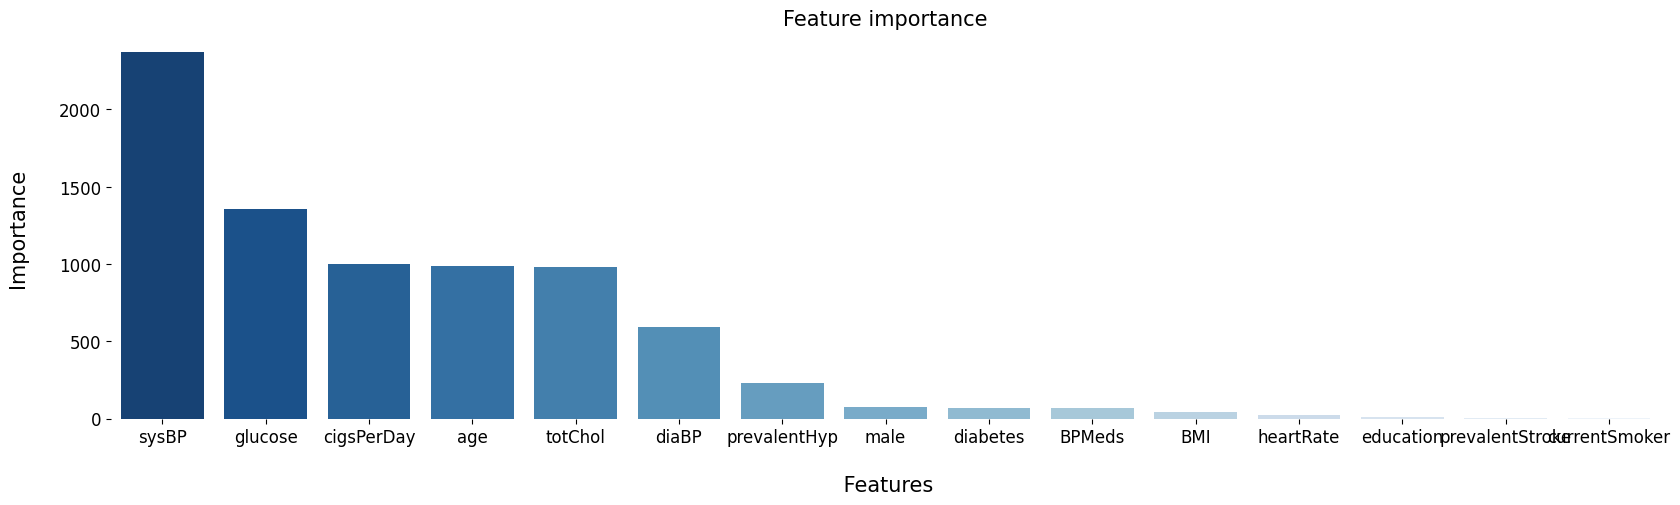

In [51]:
#Visualization of Feature Selection:

plt.figure(figsize=(20,5))
sns.barplot(x='Specs', y='Score', data=featureScores, palette = "Blues_r")
plt.box(False)
plt.title('Feature importance', fontsize=15)
plt.xlabel('\n Features', fontsize=15)
plt.ylabel('Importance \n', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [52]:
features_list = featureScores["Specs"].tolist()[:10]
features_list


['sysBP',
 'glucose',
 'cigsPerDay',
 'age',
 'totChol',
 'diaBP',
 'prevalentHyp',
 'male',
 'diabetes',
 'BPMeds']

These are the 10 best features that can be used to predict the output variable:

* Systolic Blood Pressure
* Glucose
* Age
* Cholesterin
* Cigarettes per Day
* Diastolic Blood Pressure
* Hypertensive
* Diabetes
* Blood Pressure Medication
* Gender

The columns removed are:

* Education: Due to irrelevance to outcome variable and being out of subject.
* CurrentSmoker: Due to presence of a more informative similar variable(CigsPerDay).
* PrevalentStroke: Due to high imbalance caused by this variable.
* BMI: Due to unimpactful effect on outcome variable.
* HeartRate: Due to the prediction made by sklearn algorithm.

In [53]:
#A new dataset with the most important features is created.
df = df_data[['sysBP', 'glucose','age','totChol','cigsPerDay','diaBP','prevalentHyp','diabetes','BPMeds','TenYearCHD']]
df.head()

,sysBP,glucose,age,totChol,cigsPerDay,diaBP,prevalentHyp,diabetes,BPMeds,TenYearCHD
0,106.0,77.0,39,195.0,0.0,70.0,0,0,0.0,0
1,121.0,76.0,46,250.0,0.0,81.0,0,0,0.0,0
2,127.5,70.0,48,245.0,20.0,80.0,0,0,0.0,0
4,130.0,85.0,46,285.0,23.0,84.0,0,0,0.0,0
5,180.0,99.0,43,228.0,0.0,110.0,1,0,0.0,0


<Axes: >

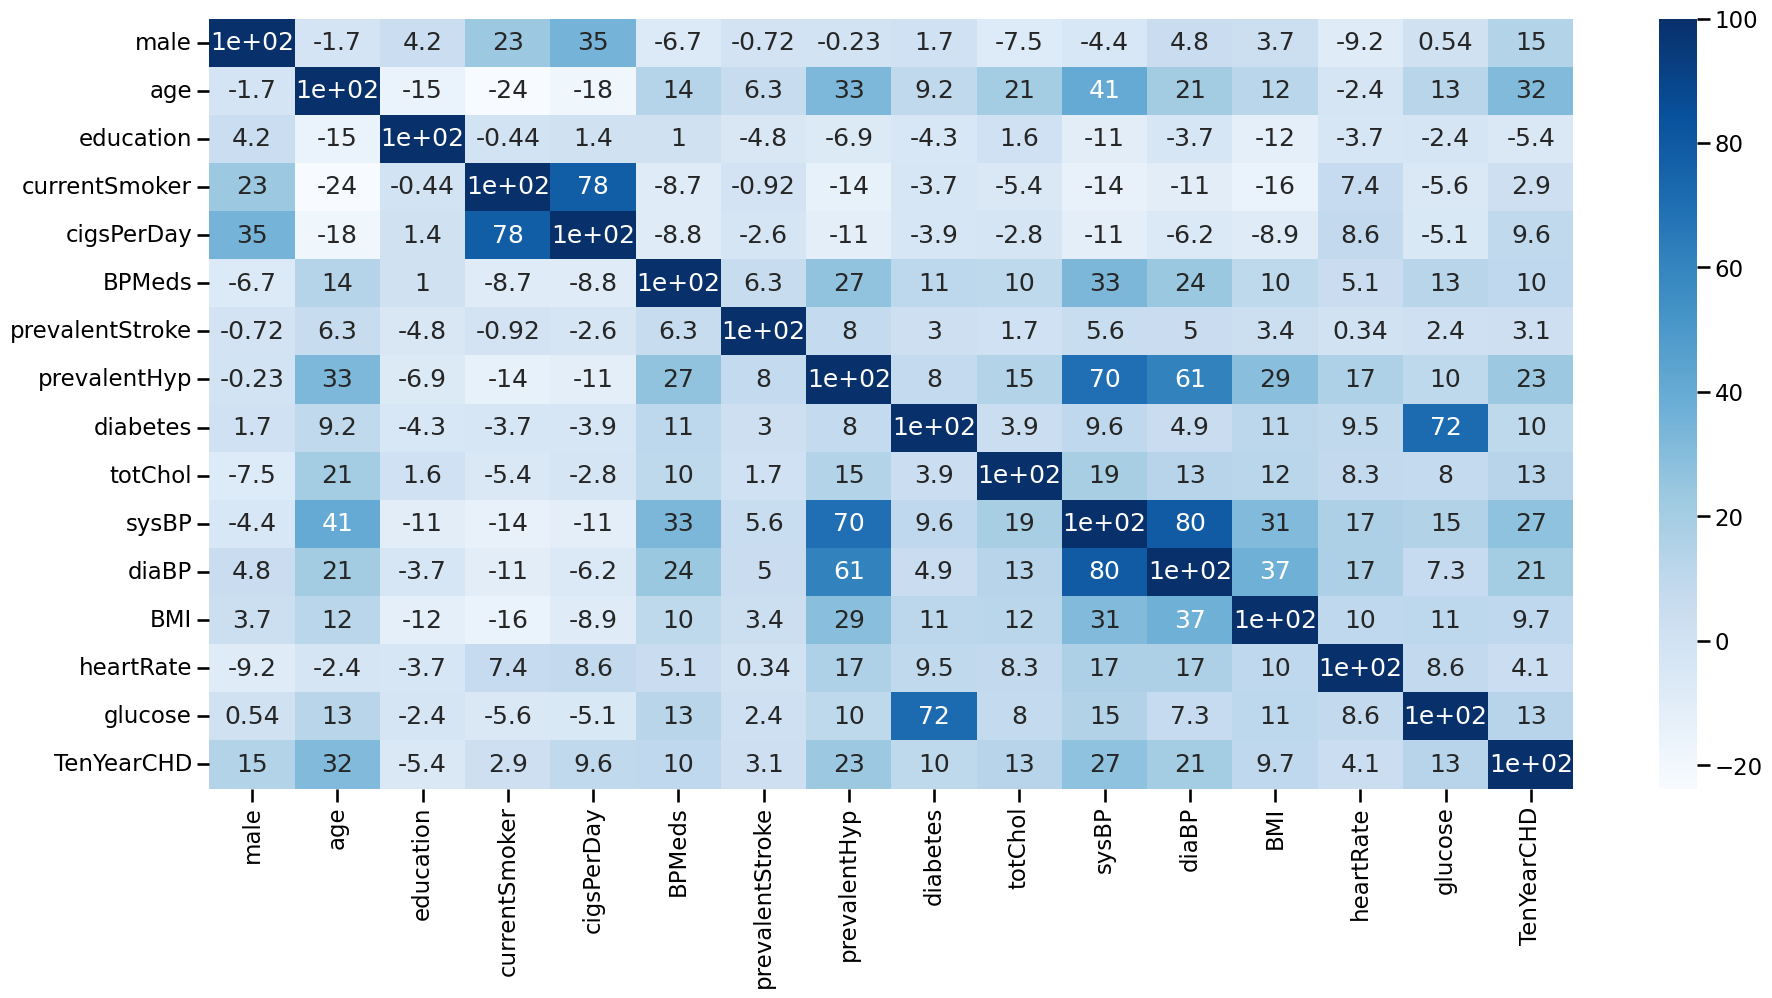

In [54]:
#Final Correlation Check:
sns.set_context('talk')
plt.figure(figsize=(22,10))
sns.heatmap(df_data.corr()*100, annot=True, cmap='Blues')

We can observe that almost all features have a strong correlation to the output variable.

## Feature Spliting And Scaling

In [55]:
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = pd.DataFrame(scaler.fit_transform(df_data), columns=df_data.columns)
df_scaled.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,6788.000000,6788.000000,6788.000000,6788.000000,6788.000000,6788.000000,6788.000000,6788.000000,6788.000000,6788.000000,6788.000000,6788.000000,6788.000000,6788.000000,6788.000000,6788.000000
mean,0.488804,0.510246,0.316343,0.501031,0.142003,0.043606,0.006629,0.389658,0.039187,0.364604,0.326152,0.389947,0.254794,0.325786,0.124958,0.500000
std,0.499911,0.226213,0.347269,0.500036,0.181216,0.204233,0.081156,0.487709,0.194053,0.128403,0.153450,0.140095,0.101610,0.121844,0.088971,0.500037
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.315789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.276353,0.218845,0.296296,0.185107,0.242424,0.090395,0.000000
50%,0.000000,0.500000,0.333333,1.000000,0.014286,0.000000,0.000000,0.000000,0.000000,0.358974,0.294833,0.370370,0.247455,0.313131,0.104520,0.500000
75%,1.000000,0.710526,0.666667,1.000000,0.285714,0.000000,0.000000,1.000000,0.000000,0.444444,0.404255,0.465608,0.310470,0.404040,0.132768,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Training And Testing Data

In [56]:
y = df['TenYearCHD']
X = df.drop(['TenYearCHD'], axis=1)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.4, random_state=1)

* The X train and test tables contain all the features and their values.
* The y train and test tables contain all the standalone features without their values.

In [57]:
scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)
print ('Train set:', train_x.shape,  train_y.shape)
print ('Test set:', test_x.shape,  test_y.shape)

Train set: (4072, 9) (4072,)
Test set: (2716, 9) (2716,)


## Predictive Modelling

### * Logistic Regression

In [58]:
#evaluation and accuracy
m1 = 'Logistic Regression'
logreg = LogisticRegression()
logreg.fit(train_x, train_y)
pred_y = logreg.predict(test_x)

from sklearn.metrics import jaccard_score
print('Accuracy of the model in jaccard similarity score is = ',
      jaccard_score(test_y, pred_y))

Accuracy of the model in jaccard similarity score is =  0.5005506607929515


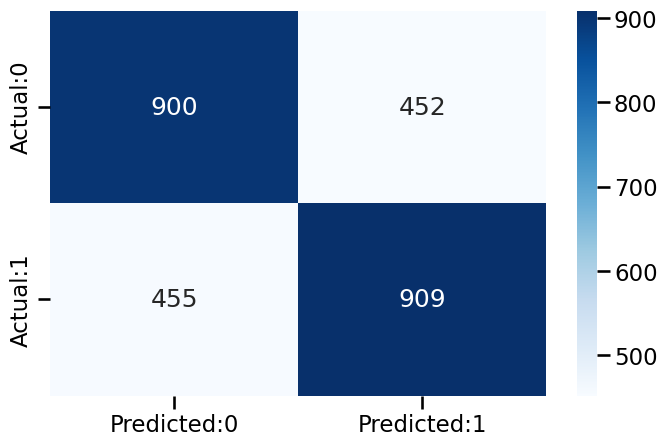

The details for confusion matrix is =
              precision    recall  f1-score   support

           0       0.66      0.67      0.66      1352
           1       0.67      0.67      0.67      1364

    accuracy                           0.67      2716
   macro avg       0.67      0.67      0.67      2716
weighted avg       0.67      0.67      0.67      2716



In [59]:
#confusion matrix

cm = confusion_matrix(test_y, pred_y)
conf_matrix = pd.DataFrame(data = cm,
                           columns = ['Predicted:0', 'Predicted:1'],
                           index =['Actual:0', 'Actual:1'])
plt.figure(figsize = (8, 5))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = "Blues")
plt.show()

print('The details for confusion matrix is =')
print (classification_report(test_y, pred_y))

### K Nearest Neighbors

In [60]:
#Evaluation And Accuracy
m2 = 'KNeighborsClassifier'
knn = KNeighborsClassifier(n_neighbors=1)
model = knn.fit(train_x, train_y)
knn_predict = knn.predict(test_x)
knn_acc_score = accuracy_score(test_y, knn_predict)

from sklearn.metrics import jaccard_score
print('Accuracy of the model in jaccard similarity score is = ',
      jaccard_score(test_y, knn_predict))

Accuracy of the model in jaccard similarity score is =  0.812192118226601


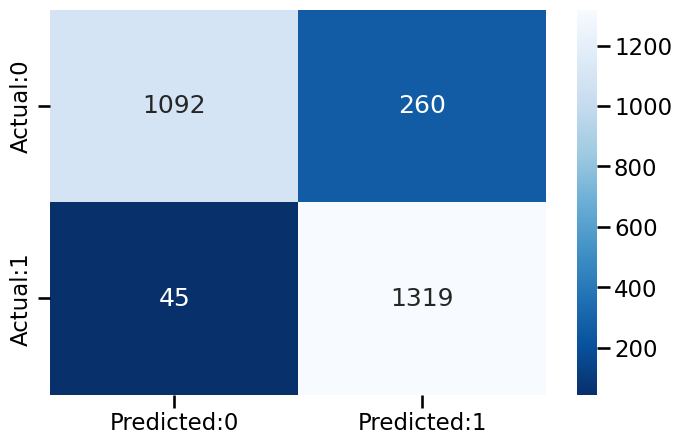

The details for confusion matrix is =
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1352
           1       0.84      0.97      0.90      1364

    accuracy                           0.89      2716
   macro avg       0.90      0.89      0.89      2716
weighted avg       0.90      0.89      0.89      2716



In [61]:
#Confusion Matrix
cm = confusion_matrix(test_y, knn_predict)
conf_matrix = pd.DataFrame(data = cm,
                           columns = ['Predicted:0', 'Predicted:1'],
                           index =['Actual:0', 'Actual:1'])
plt.figure(figsize = (8, 5))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = "Blues_r")
plt.show()

print('The details for confusion matrix is =')
print (classification_report(test_y, knn_predict))

### Decision tree

In [62]:
#Evaluation and Accuracy
m3 = 'DecisionTreeClassifier'
dt = DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 30)
dt.fit(train_x,train_y)
dt_predict = dt.predict(test_x)

from sklearn.metrics import jaccard_score
print('Accuracy of the model in jaccard similarity score is = ',
      jaccard_score(test_y, dt_predict))

Accuracy of the model in jaccard similarity score is =  0.8079754601226994


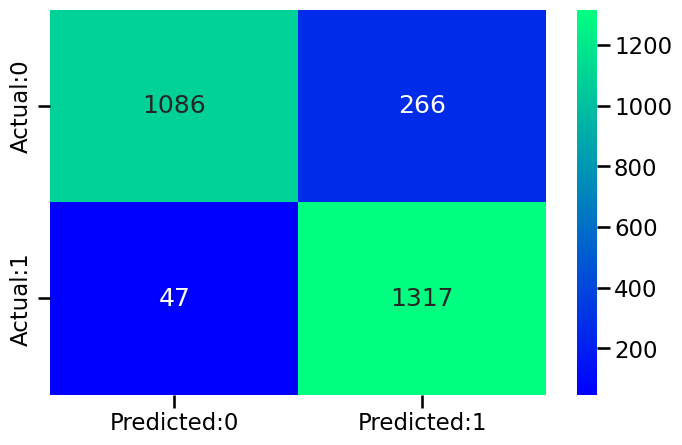

The details for confusion matrix is =
              precision    recall  f1-score   support

           0       0.96      0.80      0.87      1352
           1       0.83      0.97      0.89      1364

    accuracy                           0.88      2716
   macro avg       0.90      0.88      0.88      2716
weighted avg       0.89      0.88      0.88      2716



In [63]:
#Confusion Matrix
cm = confusion_matrix(test_y, dt_predict)
conf_matrix = pd.DataFrame(data = cm,
                           columns = ['Predicted:0', 'Predicted:1'],
                           index =['Actual:0', 'Actual:1'])
plt.figure(figsize = (8, 5))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = "winter")
plt.show()

print('The details for confusion matrix is =')
print (classification_report(test_y, dt_predict))

### Random Forest

In [64]:
#Evaluation And Accuracy
m4 = 'Random Forest Classfier'
rf = RandomForestClassifier(n_estimators=200, random_state=0,max_depth=12)
rf.fit(train_x,train_y)
rf_predict = rf.predict(test_x)

from sklearn.metrics import jaccard_score
print('Accuracy of the model in jaccard similarity score is = ',
      jaccard_score(test_y, rf_predict))

Accuracy of the model in jaccard similarity score is =  0.8130544993662865


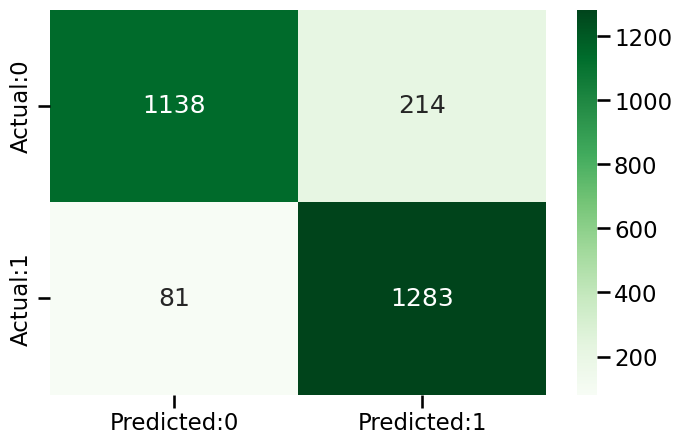

The details for confusion matrix is =
              precision    recall  f1-score   support

           0       0.93      0.84      0.89      1352
           1       0.86      0.94      0.90      1364

    accuracy                           0.89      2716
   macro avg       0.90      0.89      0.89      2716
weighted avg       0.90      0.89      0.89      2716



In [65]:
#Confusion Matrix
cm = confusion_matrix(test_y, rf_predict)
conf_matrix = pd.DataFrame(data = cm,
                           columns = ['Predicted:0', 'Predicted:1'],
                           index =['Actual:0', 'Actual:1'])
plt.figure(figsize = (8, 5))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = "Greens")
plt.show()

print('The details for confusion matrix is =')
print (classification_report(test_y, rf_predict))

### Gradient Boosting Classifier

In [66]:
m5 = 'Gradient Boosting Classifier'
gbc =  GradientBoostingClassifier()
gbc.fit(train_x,train_y)
gbc_predict = gbc.predict(test_x)

from sklearn.metrics import jaccard_score
print('Accuracy of the model in jaccard similarity score is = ',
      jaccard_score(test_y, gbc_predict))

Accuracy of the model in jaccard similarity score is =  0.5684740078256009


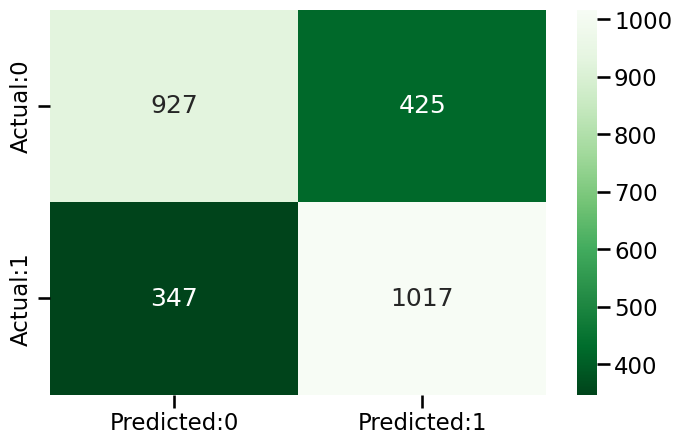

The details for confusion matrix is =
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1352
           1       0.71      0.75      0.72      1364

    accuracy                           0.72      2716
   macro avg       0.72      0.72      0.72      2716
weighted avg       0.72      0.72      0.72      2716



In [67]:
#Confusion Matrix
cm = confusion_matrix(test_y, gbc_predict)
conf_matrix = pd.DataFrame(data = cm,
                           columns = ['Predicted:0', 'Predicted:1'],
                           index =['Actual:0', 'Actual:1'])
plt.figure(figsize = (8, 5))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = "Greens_r")
plt.show()

print('The details for confusion matrix is =')
print (classification_report(test_y, gbc_predict))

## Hyperparameter Tuning for best Classifier

### Random Forest

In [68]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [70]:
# Use the random grid to search for best hyperparameters
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation,
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 150,
                               cv = 2,
                               verbose=2,
                               random_state=7,
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(train_x,train_y)

Fitting 2 folds for each of 150 candidates, totalling 300 fits


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_iter=150,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=7, verbose=2)

In [71]:
rf_hyper = rf_random.best_estimator_
rf_hyper.fit(train_x,train_y)
print("Accuracy on training set is : {}".format(rf_hyper.score(train_x,train_y)))
print("Accuracy on validation set is : {}".format(rf_hyper.score(test_x, test_y)))
rf_predict = rf_hyper.predict(test_x)
print("Accuracy of Hyper-tuned Random Forest Classifier:",jaccard_score(test_y, rf_predict))
print(classification_report(test_y, rf_predict))

Accuracy on training set is : 0.9997544204322201
Accuracy on validation set is : 0.9458762886597938
Accuracy of Hyper-tuned Random Forest Classifier: 0.8991769547325102
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1352
           1       0.93      0.96      0.95      1364

    accuracy                           0.95      2716
   macro avg       0.95      0.95      0.95      2716
weighted avg       0.95      0.95      0.95      2716



### Gradient Boosting Classifier

In [75]:
#Number of trees
n_estimators = [int(i) for i in np.linspace(start=100,stop=1000,num=10)]
#Number of features to consider at every split
max_features = ['auto','sqrt']
#Maximum number of levels in tree
max_depth = [int(i) for i in np.linspace(10, 100, num=10)]
max_depth.append(None)
#Minimum number of samples required to split a node
min_samples_split=[2,5,10]
#Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,4]

#Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [76]:
gb=GradientBoostingClassifier(random_state=0)
#Random search of parameters, using 3 fold cross validation,
#search across 100 different combinations
gb_random = RandomizedSearchCV(estimator=gb, param_distributions=random_grid,
                              n_iter=150, scoring='f1',
                              cv=2, verbose=2, random_state=0, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
gb_random.fit(train_x,train_y)

Fitting 2 folds for each of 150 candidates, totalling 300 fits


RandomizedSearchCV(cv=2, estimator=GradientBoostingClassifier(random_state=0),
                   n_iter=150, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=0, return_train_score=True, scoring='f1',
                   verbose=2)

In [77]:
gb_hyper = gb_random.best_estimator_
gb_hyper.fit(train_x,train_y)
print("Accuracy on training set is : {}".format(gb_hyper.score(train_x,train_y)))
print("Accuracy on validation set is : {}".format(gb_hyper.score(test_x, test_y)))
gbc_predict = gb_hyper.predict(test_x)
gbc_acc_score = accuracy_score(test_y, gbc_predict)
print("Accuracy of Hyper-tuned Gradient Boosting Classifier:",gbc_acc_score*100,'\n')
print(classification_report(test_y, gbc_predict))

Accuracy on training set is : 1.0
Accuracy on validation set is : 0.946980854197349
Accuracy of Hyper-tuned Gradient Boosting Classifier: 94.6980854197349 

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1352
           1       0.93      0.96      0.95      1364

    accuracy                           0.95      2716
   macro avg       0.95      0.95      0.95      2716
weighted avg       0.95      0.95      0.95      2716



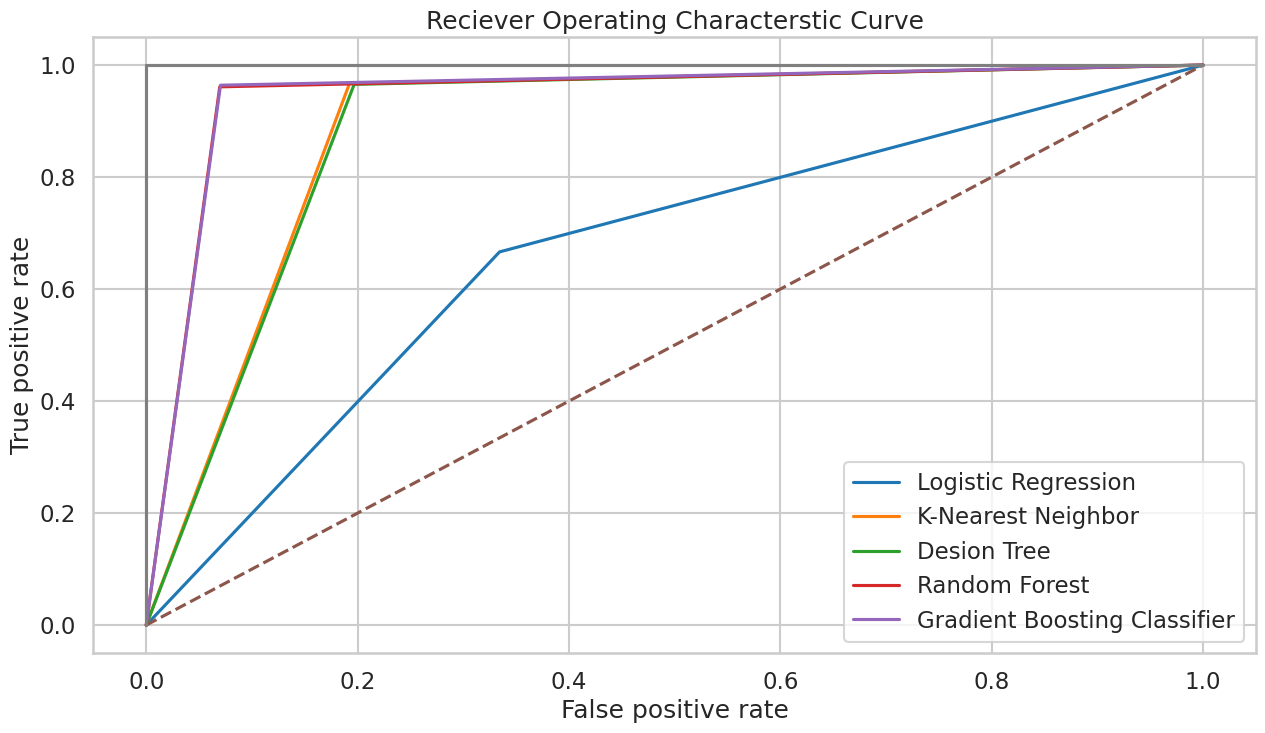

In [78]:
lr_false_positive_rate,lr_true_positive_rate,lr_threshold = roc_curve(test_y,pred_y)
knn_false_positive_rate,knn_true_positive_rate,knn_threshold = roc_curve(test_y,knn_predict)
dt_false_positive_rate,dt_true_positive_rate,dt_threshold = roc_curve(test_y,dt_predict)
rf_false_positive_rate,rf_true_positive_rate,rf_threshold = roc_curve(test_y,rf_predict)
gbc_false_positive_rate,gbc_true_positive_rate,gbc_threshold = roc_curve(test_y,gbc_predict)


sns.set_style('whitegrid')
plt.figure(figsize=(15,8), facecolor='w')
plt.title('Reciever Operating Characterstic Curve')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='Logistic Regression')
plt.plot(knn_false_positive_rate,knn_true_positive_rate,label='K-Nearest Neighbor')
plt.plot(dt_false_positive_rate,dt_true_positive_rate,label='Desion Tree')
plt.plot(rf_false_positive_rate,rf_true_positive_rate,label='Random Forest')
plt.plot(gbc_false_positive_rate,gbc_true_positive_rate,label='Gradient Boosting Classifier')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

## Model Evaluation

In [79]:
model_ev = pd.DataFrame({'Model': ['Logistic Regression','K-Nearest Neighbour','Decision Tree',
                                   'Random Forest','Gradient Boosting'], 'Accuracy': [jaccard_score(test_y, pred_y), jaccard_score(test_y, knn_predict),
                                                                                     jaccard_score(test_y, dt_predict), jaccard_score(test_y, rf_predict),jaccard_score(test_y, gbc_predict)]})
model_ev

,Model,Accuracy
0,Logistic Regression,0.500551
1,K-Nearest Neighbour,0.812192
2,Decision Tree,0.807975
3,Random Forest,0.899177
4,Gradient Boosting,0.901302


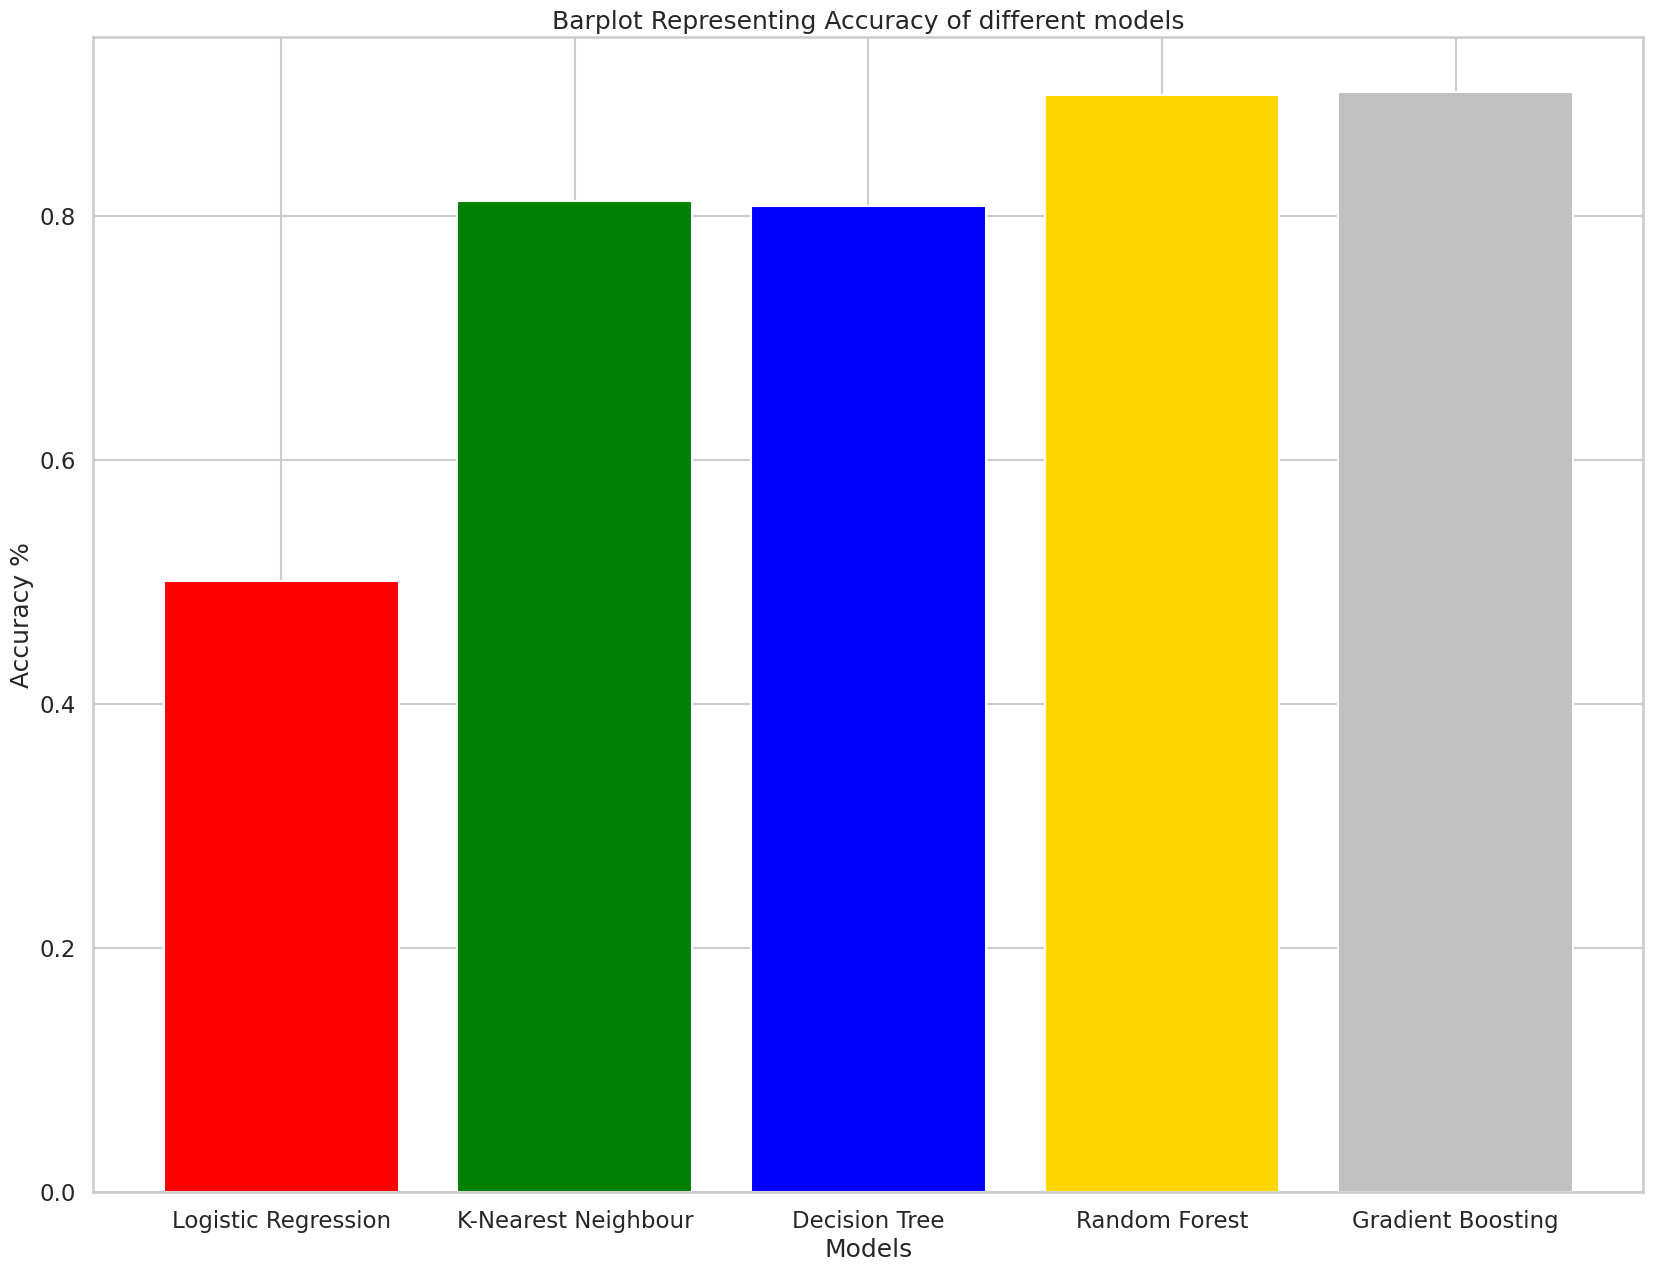

In [80]:
colors = ['red','green','blue','gold','silver']
plt.figure(figsize=(20,15), facecolor='w')
plt.title("Barplot Representing Accuracy of different models")
plt.ylabel("Accuracy %")
plt.xlabel("Models")
plt.bar(model_ev['Model'],model_ev['Accuracy'],color = colors)
plt.show()

## Ensembling
* In order to increase the accuracy of the model we use ensembling. Here we use stacking technique. We stack the 4 highest accuracy yielding models to create an ensembled model

In [81]:
scv=StackingCVClassifier(classifiers=[rf_hyper, gb_hyper, knn, dt], meta_classifier= rf)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.4, random_state=1)
scv.fit(train_x.values,train_y.values)
scv_predict = scv.predict(test_x)
scv_acc_score = accuracy_score(test_y, scv_predict)
print("Accuracy of StackingCVClassifier:",scv_acc_score*100,'\n')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Accuracy of StackingCVClassifier: 95.65537555228278 



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


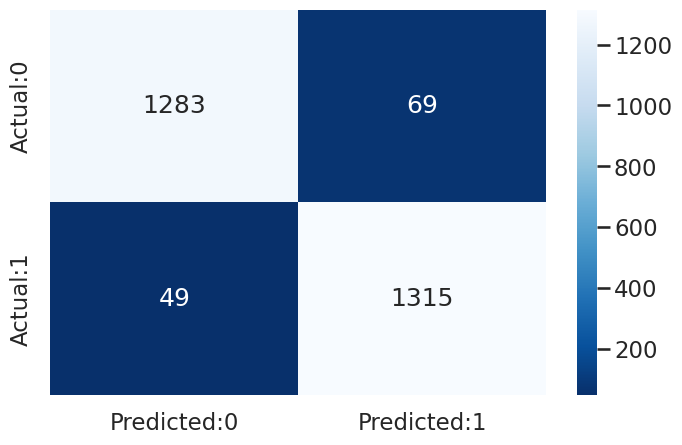

The details for confusion matrix is =
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1352
           1       0.95      0.96      0.96      1364

    accuracy                           0.96      2716
   macro avg       0.96      0.96      0.96      2716
weighted avg       0.96      0.96      0.96      2716



In [82]:
cm = confusion_matrix(test_y, scv_predict)
conf_matrix = pd.DataFrame(data = cm,
                           columns = ['Predicted:0', 'Predicted:1'],
                           index =['Actual:0', 'Actual:1'])
plt.figure(figsize = (8, 5))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = "Blues_r")
plt.show()

print('The details for confusion matrix is =')
print (classification_report(test_y, scv_predict))

## Conclusion

In [91]:
model_ev = model_ev.append({"Model":"Stacking Ensemble", "Accuracy":scv_acc_score*100}, ignore_index=True)
model_ev

AttributeError: 'DataFrame' object has no attribute 'append'

In [93]:

model_ev = pd.concat([model_ev, pd.DataFrame({"Model":"Stacking Ensemble", "Accuracy":scv_acc_score*100}, index=[0])], ignore_index=True)

* Individual Best Model: Gradient Boosting( 96.6% )
* Overall Best Model: Stacking Ensemble Classification( 97% )

In [94]:
model_ev

,Model,Accuracy
0,Logistic Regression,0.500551
1,K-Nearest Neighbour,0.812192
2,Decision Tree,0.807975
3,Random Forest,0.899177
4,Gradient Boosting,0.901302
5,Stacking Ensemble,95.655376


In [97]:
import pickle

# Save the model to a pickle file
pickle_filename = 'test1.pkl'
with open(pickle_filename, 'wb') as file:
    pickle.dump(scv, file)

print(f"Model saved as {pickle_filename}")

Model saved as test1.pkl


In [106]:
import pickle
import numpy as np
# features = ['sysBP', 'glucose', 'age', 'totChol', 'cigsPerDay', 'diaBP', 'prevalentHyp', 'diabetes', 'BPMeds']
idk = 120,40,30,250,2,90,71,106,10
# idk = 125,30,24,100,0,90,1,1,0
# idk = 140,110,44,190,3,100,1,1,0
int_features = [int(x)  for x in idk]
final = [np.array(int_features)]
model = pickle.load(open('test1.pkl','rb'))
prediction = model.predict_proba(final)
print(prediction)
# numeric_value = prediction[0][0]
# numeric_value_new = numeric_value*100
# sliced_value = round(numeric_value_new,3)
# print("prediction: ", prediction)
# print("prediction: ", sliced_value)

[[0.96711118 0.03288882]]
